# Blind

In [ ]:
import numpy as np
from numpy import ndarray
import portion as P


class BlindOptimalDesignStrips:
    def __init__(
        self,
        x: ndarray,
        inclusions: ndarray,
        threshold: float = 1e-2
    ) -> None:
        self.x = x
        self.inclusions = inclusions
        self.threshold = threshold
        self.rng = np.random.default_rng()

        self.best_design = None
        self.best_cost = None

    def generate_initial_design(self):
        bars = []
        level = 0
        for p in self.inclusions:
            next_level = level + p
            if next_level < 1-1e-9:
                interval = P.closed(level, next_level)
                level = next_level
            elif next_level > 1+1e-9:
                interval = P.closed(level, 1) | P.closed(0, next_level-1)
                level = next_level-1
            else:
                interval = P.closed(level, 1)
                level = 0
            bars.append(interval)

        events = []
        for i, bar in enumerate(bars):
            for interval in bar:
                events.append((interval.lower, 'start', i))
                events.append((interval.upper, 'end', i))

        events.sort()

        active = set()
        design = P.IntervalDict()
        last_point = 0

        for point, event_type, bar_index in events:
            if event_type == 'start':
                active.add(bar_index)
            elif event_type == 'end':
                if last_point != point:
                    design[P.open(round(last_point, 9), round(point, 9))] = set(active)
                active.remove(bar_index)

            last_point = point
        #print(design)
        return design

    def clean_design(self, design: P.IntervalDict) -> P.IntervalDict:
        cleaned_design = P.IntervalDict()
        samples = design.values()
        for i, intervals in enumerate(design):
            for interval in intervals:
                cleaned_design[interval.replace(P.OPEN, interval.lower, interval.upper, P.OPEN)] = samples[i]
        return cleaned_design

    def length_of_interval(self, interval):
        length = []
        for i in interval:
            if i.upper - i.lower != 0:
                length.append(i.upper - i.lower)
        return length

    def match_interval(self, interval, length):
        #print("itervalleng", interval, length)
        for i in interval:
            if i.upper - i.lower >= length - 1e-6:
                return i.lower

    def generate_new_design(self, design: P.IntervalDict, num_changes: int) -> P.IntervalDict:
        new_design = design.copy()
        for _ in range(num_changes):
            intervals = new_design.keys()
            samples = new_design.values()
            index1, index2 = self.rng.choice(len(intervals), size=2, replace=False)
            interval1, interval2 = intervals[index1], intervals[index2]
            if self.length_of_interval(interval1) and self.length_of_interval(interval2):
                sample1, sample2 = samples[index1], samples[index2]
                n1 = self.rng.choice(list(sample1 - sample2))
                n2 = self.rng.choice(list(sample2 - sample1))
                #length = self.rng.choice([0.01, 0.05, 0.1])
                length = 0.01
                valid_length = round(min(*self.length_of_interval(interval1), *self.length_of_interval(interval2), length), 9)
                interval1_lower = self.match_interval(interval1, valid_length)
                interval2_lower = self.match_interval(interval2, valid_length)
                new_design[P.open(interval1_lower, round(interval1_lower+valid_length, 9))] = sample1 - {n1} | {n2}
                new_design[P.open(interval2_lower, round(interval2_lower+valid_length, 9))] = sample2 - {n2} | {n1}


        return new_design

    def make_output_design(self, design: P.IntervalDict) -> list:
        output = []
        samples = design.values()
        for i, intervals in enumerate(design):
            length = 0
            for interval in intervals:
                length += interval.upper - interval.lower
            output.append((np.array(list(samples[i])), round(length, 9)))
        return output

    def criteria(self, design):
        output_design = self.make_output_design(design)
        extract_inclusion_x = np.array([np.sum(self.x[sample[0]] / self.inclusions[sample[0]]) for sample in output_design])
        probabilities = np.array([sample[1] for sample in output_design])
        return np.sum((extract_inclusion_x - np.sum(self.x)) ** 2 * probabilities)

    def run(self, max_iterations, num_changes):
        current_design = self.generate_initial_design()
        iterations = 0
        while iterations < max_iterations:
            iterations += 1
            print(f'\r{iterations/max_iterations}', end=' ')
            new_design = self.generate_new_design(current_design, num_changes)
            new_cost = self.criteria(new_design) + self.rng.random() * 0.0000001
            print('old and new', self.best_cost, new_cost)
            if self.best_design is None or new_cost < self.best_cost:
                self.best_design = self.make_output_design(new_design)
                self.best_cost = self.criteria(new_design)
                print('cost',iterations, self.best_cost/self.threshold)
                if self.best_cost < self.threshold:
                    return iterations
                current_design = new_design
        return iterations


# Bardia Blind

In [ ]:
import numpy as np
from numpy import ndarray
import portion as P
import random


class BBlindOptimalDesignStrips:

    def __init__(
        self,
        x: ndarray,
        strip_size,
        inclusions: ndarray,
        threshold: float = 1e-2
    ) -> None:
        self.x = x
        self.strip_size = strip_size
        self.inclusions = inclusions
        self.threshold = threshold
        self.rng = np.random.default_rng()

        self.best_design = None
        self.best_cost = None

    def generate_initial_design(self):
        bars = []
        level = 0
        for p in self.inclusions:
            next_level = level + p
            if next_level < 1-1e-9:
                interval = P.closed(level, next_level)
                level = next_level
            elif next_level > 1+1e-9:
                interval = P.closed(level, 1) | P.closed(0, next_level-1)
                level = next_level-1
            else:
                interval = P.closed(level, 1)
                level = 0
            bars.append(interval)

        events = []
        for i, bar in enumerate(bars):
            for interval in bar:
                events.append((interval.lower, 'start', i))
                events.append((interval.upper, 'end', i))

        events.sort()

        active = set()
        design = P.IntervalDict()
        last_point = 0

        for point, event_type, bar_index in events:
            if event_type == 'start':
                active.add(bar_index)
            elif event_type == 'end':
                if last_point != point:
                    design[P.open(round(last_point, 9), round(point, 9))] = set(active)
                active.remove(bar_index)

            last_point = point
        #print(design)
        return design

    def convert_to_samples(self):
        input_design = self.generate_initial_design()
        #print('input designsns',input_design)
        design = []
        for (start_end, units) in input_design.items():
            start = start_end.lower
            end = start_end.upper
            sample_units = np.array(list(units))

            # Calculate the probability
            probability = end - start

            # Append the result in the required format
            design.append((sample_units, probability))

        #print('ready designs',design)
        return design

    def striping_design(self, strip_size):
        striped_design = []
        current_prob = 0.0
        initial_design = self.convert_to_samples()
        #print('injaaaaa?',initial_design)
        for sample, prob in initial_design:
            next_prob = round(current_prob + prob, 7)  # Total probability range for this sample
            # Partition this sample's probability range into strips of size strip_size
         #   print('injana chie?', prob, current_prob, next_prob)
            while current_prob < next_prob:
          #      print('inja gir kardi?',current_prob, next_prob)
                end_prob = round(min(current_prob + strip_size, next_prob),7)

                striped_design.append((sample, current_prob, end_prob))
                current_prob = round(end_prob,7)

        return striped_design


    def generate_new_design(self, design, num_changes: int):
        output_design = self.striping_design(self.strip_size)
        #print(output_design)
        for _ in range(num_changes):
            sample_indices = random.sample(range(len(output_design)), 2)
            sample1_index, sample2_index = sample_indices[0], sample_indices[1]

            sample1 = output_design[sample1_index]
            sample2 = output_design[sample2_index]
            prob1 = round(sample1[2] - sample1[1], 7)
            prob2 = round(sample2[2] - sample2[1], 7)
            setdiff1 = np.setdiff1d(sample1[0], sample2[0])
            setdiff2 = np.setdiff1d(sample2[0], sample1[0])

            if setdiff1.size > 0 and setdiff2.size > 0 and prob1 == prob2:
                unit1 = random.choice(setdiff1)
                unit2 = random.choice(setdiff2)

                position1 = np.where(sample1[0] == unit1)[0][0]
                position2 = np.where(sample2[0] == unit2)[0][0]

                # Create copies of the arrays to modify
                new_sample1 = sample1[0].copy()
                new_sample2 = sample2[0].copy()

                # Swap the units in the new copies
                new_sample1[position1] = unit2
                new_sample2[position2] = unit1

                # Ensure probability ranges are preserved
                output_design[sample1_index] = (new_sample1, sample1[1], sample1[2])  # Keep the original probability bounds
                output_design[sample2_index] = (new_sample2, sample2[1], sample2[2])  # Keep the original probability bounds
        new_design = output_design
        return new_design


    def criteria(self, design):

        #print('design design', design)

        extract_inclusion_x = np.array([np.sum(self.x[sample[0]] / self.inclusions[sample[0]]) for sample in design])
        probabilities = np.array([sample[2]-sample[1] for sample in design])
        return np.sum((extract_inclusion_x - np.sum(self.x)) ** 2 * probabilities)

    def run(self, max_iterations, num_changes):
        current_design = self.generate_initial_design()
        #print(current_design)
        #print('curent', current_design)
        iterations = 0
        while iterations < max_iterations:
            iterations += 1
            print(f'\r{iterations/max_iterations}', end=' ')
            new_design = self.generate_new_design(current_design, num_changes)
            new_cost = self.criteria(new_design) + self.rng.random() * 0.0000001
            print('old and new', self.best_cost, new_cost)
            if self.best_design is None or new_cost < self.best_cost:
                self.best_design = new_design
                self.best_cost = self.criteria(new_design)
                print('cost',iterations, self.best_cost/self.threshold)
                if self.best_cost < self.threshold:
                    return iterations
                current_design = new_design
        return iterations


# Bardia A*

In [ ]:
import numpy as np
from numpy import ndarray
import heapq
import portion as P


class AStarOptimalDesignStrips:
    def __init__(
        self,
        x: ndarray,
        inclusions: ndarray,
        threshold: float = 1e-2
    ) -> None:
        self.x = x
        self.inclusions = inclusions
        self.threshold = threshold
        self.rng = np.random.default_rng()

        self.best_design = None
        self.best_cost = None

    def generate_initial_design(self):
        bars = []
        level = 0
        for p in self.inclusions:
            next_level = level + p
            if next_level < 1-1e-9:
                interval = P.closed(level, next_level)
                level = next_level
            elif next_level > 1+1e-9:
                interval = P.closed(level, 1) | P.closed(0, next_level-1)
                level = next_level-1
            else:
                interval = P.closed(level, 1)
                level = 0
            bars.append(interval)

        events = []
        for i, bar in enumerate(bars):
            for interval in bar:
                events.append((interval.lower, 'start', i))
                events.append((interval.upper, 'end', i))

        events.sort()

        active = set()
        design = P.IntervalDict()
        last_point = 0

        for point, event_type, bar_index in events:
            if event_type == 'start':
                active.add(bar_index)
            elif event_type == 'end':
                if last_point != point:
                    design[P.open(round(last_point, 9), round(point, 9))] = set(active)
                active.remove(bar_index)

            last_point = point
        return design

    def clean_design(self, design: P.IntervalDict) -> P.IntervalDict:
        cleaned_design = P.IntervalDict()
        samples = design.values()
        for i, intervals in enumerate(design):
            for interval in intervals:
                cleaned_design[interval.replace(P.OPEN, interval.lower, interval.upper, P.OPEN)] = samples[i]
        return cleaned_design

    def length_of_interval(self, interval):
        length = []
        for i in interval:
            if i.upper - i.lower != 0:
                length.append(i.upper - i.lower)
        return length

    def match_interval(self, interval, length):
        #print("itervalleng", interval, length)
        for i in interval:
            if i.upper - i.lower >= length - 1e-6:
                return i.lower

    def generate_new_design(self, design: P.IntervalDict, num_changes: int) -> P.IntervalDict:
        new_design = design.copy()
        for _ in range(num_changes):
            intervals = new_design.keys()
            samples = new_design.values()
            index1, index2 = self.rng.choice(len(intervals), size=2, replace=False)
            interval1, interval2 = intervals[index1], intervals[index2]
            if self.length_of_interval(interval1) and self.length_of_interval(interval2):
                sample1, sample2 = samples[index1], samples[index2]
                n1 = self.rng.choice(list(sample1 - sample2))
                n2 = self.rng.choice(list(sample2 - sample1))
                #length = self.rng.choice([0.01, 0.05, 0.1])
                length = 0.01
                valid_length = round(min(*self.length_of_interval(interval1), *self.length_of_interval(interval2), length), 9)
                interval1_lower = self.match_interval(interval1, valid_length)
                interval2_lower = self.match_interval(interval2, valid_length)
                new_design[P.open(interval1_lower, round(interval1_lower+valid_length, 9))] = sample1 - {n1} | {n2}
                new_design[P.open(interval2_lower, round(interval2_lower+valid_length, 9))] = sample2 - {n2} | {n1}


        return new_design

    def make_output_design(self, design: P.IntervalDict) -> list:
        output = []
        samples = design.values()
        for i, intervals in enumerate(design):
            length = 0
            for interval in intervals:
                length += interval.upper - interval.lower
            output.append((np.array(list(samples[i])), round(length, 9)))
        return output

    def criteria(self, design):
        output_design = self.make_output_design(design)
        extract_inclusion_x = np.array([np.sum(self.x[sample[0]] / self.inclusions[sample[0]]) for sample in output_design])
        probabilities = np.array([sample[1] for sample in output_design])
        return np.sum((extract_inclusion_x - np.sum(self.x)) ** 2 * probabilities)

    def run(self, max_iterations, num_new_nodes, max_open_set_size, num_changes):
        open_set = []
        initial_design = self.generate_initial_design()
        heapq.heappush(open_set, (self.criteria(initial_design), initial_design))
        closed_set = set()
        iterations = 0
        new_cost = self.criteria(initial_design)

        while open_set and iterations < max_iterations:
            iterations += 1
            print(f'\r{iterations/max_iterations}', end=' ')

            print('new and best',new_cost, self.best_cost)
            _, current_design = heapq.heappop(open_set)
            if tuple(map(tuple, current_design)) in closed_set:
                continue
            closed_set.add(tuple(map(tuple, current_design)))
            for _ in range(num_new_nodes):
                new_design = self.generate_new_design(current_design, num_changes)
                if tuple(map(tuple, new_design)) not in closed_set:
                    new_cost = self.criteria(new_design) + self.rng.random() * 0.0000001
                    if len(open_set) < max_open_set_size:
                        heapq.heappush(open_set, (new_cost, new_design))
                    else:
                        heapq.heappushpop(open_set, (new_cost, new_design))
                    if self.best_design is None or new_cost < self.best_cost:
                        self.best_design = self.make_output_design(new_design)
                        self.best_cost = self.criteria(new_design)
                        print('new_cost',iterations, round(self.best_cost/self.threshold, 2), len(new_design))
                        if self.best_cost < self.threshold:
                            return iterations
        return iterations


# A*

In [ ]:
!pip install portion

In [ ]:
import numpy as np
from numpy import ndarray
import heapq
import portion as P


class AStarOptimalDesignStrips:
    def __init__(
        self,
        x: ndarray,
        inclusions: ndarray,
        threshold: float = 1e-2
    ) -> None:
        self.x = x
        self.inclusions = inclusions
        self.threshold = threshold
        self.rng = np.random.default_rng()

        self.best_design = None
        self.best_cost = None

    def generate_initial_design(self):
        bars = []
        level = 0
        for p in self.inclusions:
            next_level = level + p
            if next_level < 1-1e-9:
                interval = P.closed(level, next_level)
                level = next_level
            elif next_level > 1+1e-9:
                interval = P.closed(level, 1) | P.closed(0, next_level-1)
                level = next_level-1
            else:
                interval = P.closed(level, 1)
                level = 0
            bars.append(interval)

        events = []
        for i, bar in enumerate(bars):
            for interval in bar:
                events.append((interval.lower, 'start', i))
                events.append((interval.upper, 'end', i))

        events.sort()

        active = set()
        design = P.IntervalDict()
        last_point = 0

        for point, event_type, bar_index in events:
            if event_type == 'start':
                active.add(bar_index)
            elif event_type == 'end':
                if last_point != point:
                    design[P.open(round(last_point, 9), round(point, 9))] = set(active)
                active.remove(bar_index)

            last_point = point
        #print(design)
        return design

    def clean_design(self, design: P.IntervalDict) -> P.IntervalDict:
        cleaned_design = P.IntervalDict()
        samples = design.values()
        for i, intervals in enumerate(design):
            for interval in intervals:
                cleaned_design[interval.replace(P.OPEN, interval.lower, interval.upper, P.OPEN)] = samples[i]
        return cleaned_design

    def length_of_interval(self, interval):
        length = []
        for i in interval:
            if i.upper - i.lower != 0:
                length.append(i.upper - i.lower)
        return length

    def match_interval(self, interval, length):
        #print("itervalleng", interval, length)
        for i in interval:
            if i.upper - i.lower >= length - 1e-6:
                return i.lower

    def generate_new_design(self, design: P.IntervalDict, num_changes: int) -> P.IntervalDict:
        new_design = design.copy()
        for _ in range(num_changes):
            intervals = new_design.keys()
            samples = new_design.values()
            index1, index2 = self.rng.choice(len(intervals), size=2, replace=False)
            interval1, interval2 = intervals[index1], intervals[index2]
            if self.length_of_interval(interval1) and self.length_of_interval(interval2):
                sample1, sample2 = samples[index1], samples[index2]
                n1 = self.rng.choice(list(sample1 - sample2))
                n2 = self.rng.choice(list(sample2 - sample1))
                #length = self.rng.choice([0.01, 0.05, 0.1])
                length = 0.01
                valid_length = round(min(*self.length_of_interval(interval1), *self.length_of_interval(interval2), length), 9)
                interval1_lower = self.match_interval(interval1, valid_length)
                interval2_lower = self.match_interval(interval2, valid_length)
                new_design[P.open(interval1_lower, round(interval1_lower+valid_length, 9))] = sample1 - {n1} | {n2}
                new_design[P.open(interval2_lower, round(interval2_lower+valid_length, 9))] = sample2 - {n2} | {n1}


        return new_design

    def make_output_design(self, design: P.IntervalDict) -> list:
        output = []
        samples = design.values()
        for i, intervals in enumerate(design):
            length = 0
            for interval in intervals:
                length += interval.upper - interval.lower
            output.append((np.array(list(samples[i])), round(length, 9)))
        return output

    def criteria(self, design):
        output_design = self.make_output_design(design)
        extract_inclusion_x = np.array([np.sum(self.x[sample[0]] / self.inclusions[sample[0]]) for sample in output_design])
        probabilities = np.array([sample[1] for sample in output_design])
        return np.sum((extract_inclusion_x - np.sum(self.x)) ** 2 * probabilities)

    def run(self, max_iterations, num_new_nodes, max_open_set_size, num_changes):
        open_set = []
        initial_design = self.generate_initial_design()
        heapq.heappush(open_set, (self.criteria(initial_design), initial_design))
        closed_set = set()
        iterations = 0
        new_cost = self.criteria(initial_design)

        while open_set and iterations < max_iterations:
            iterations += 1
            print(f'\r{iterations/max_iterations}', end=' ')

            print('new and best',new_cost, self.best_cost)
            _, current_design = heapq.heappop(open_set)
            if tuple(map(tuple, current_design)) in closed_set:
                continue
            closed_set.add(tuple(map(tuple, current_design)))
            for _ in range(num_new_nodes):
                new_design = self.generate_new_design(current_design, num_changes)
                if tuple(map(tuple, new_design)) not in closed_set:
                    new_cost = self.criteria(new_design) + self.rng.random() * 0.0000001
                    if len(open_set) < max_open_set_size:
                        heapq.heappush(open_set, (new_cost, new_design))
                    else:
                        heapq.heappushpop(open_set, (new_cost, new_design))
                    if self.best_design is None or new_cost < self.best_cost:
                        self.best_design = self.make_output_design(new_design)
                        self.best_cost = self.criteria(new_design)
                        print('new_cost',iterations, round(self.best_cost/self.threshold, 2), len(new_design))
                        if self.best_cost < self.threshold:
                            return iterations
        return iterations


# Bardia Last try!

In [ ]:
import numpy as np
from numpy import ndarray
import heapq
import portion as P
import json



class B1AStarOptimalDesignStrips:
    def __init__(
        self,
        x: ndarray,
        y: ndarray,
        inclusions: ndarray,
        threshold_x: float = 1e-2,
        threshold_y: float = 1e-2,
        length: float = 1e-5

    ) -> None:
        self.x = x
        self.y = y
        self.inclusions = inclusions
        self.threshold_y = threshold_y
        self.threshold_x = threshold_x
        self.length = length
        self.rng = np.random.default_rng()

        self.best_design = None
        self.best_cost = None

    def generate_initial_design(self):
        bars = []
        level = 0
        for p in self.inclusions:
            next_level = level + p
            if next_level < 1-1e-9:
                interval = P.closed(level, next_level)
                level = next_level
            elif next_level > 1+1e-9:
                interval = P.closed(level, 1) | P.closed(0, next_level-1)
                level = next_level-1
            else:
                interval = P.closed(level, 1)
                level = 0
            bars.append(interval)

        events = []
        for i, bar in enumerate(bars):
            for interval in bar:
                events.append((interval.lower, 'start', i))
                events.append((interval.upper, 'end', i))

        events.sort()

        active = set()
        design = P.IntervalDict()
        last_point = 0

        for point, event_type, bar_index in events:
            if event_type == 'start':
                active.add(bar_index)
            elif event_type == 'end':
                if last_point != point:
                    design[P.open(round(last_point, 9), round(point, 9))] = set(active)
                active.remove(bar_index)

            last_point = point
        return design

    def clean_design(self, design: P.IntervalDict) -> P.IntervalDict:
        cleaned_design = P.IntervalDict()
        samples = design.values()
        for i, intervals in enumerate(design):
            for interval in intervals:
                cleaned_design[interval.replace(P.OPEN, interval.lower, interval.upper, P.OPEN)] = samples[i]
        return cleaned_design

    def length_of_interval(self, interval):
        length = []
        for i in interval:
            if i.upper - i.lower != 0:
                length.append(i.upper - i.lower)
        return length

    def match_interval(self, interval, length):
        #print("itervalleng", interval, length)
        for i in interval:
            if i.upper - i.lower >= length - 1e-6:
                return i.lower

    def generate_new_design(self, design: P.IntervalDict, num_changes: int) -> P.IntervalDict:
        new_design = design.copy()
        for _ in range(num_changes):
            intervals = new_design.keys()
            samples = new_design.values()
            index1, index2 = self.rng.choice(len(intervals), size=2, replace=False)
            interval1, interval2 = intervals[index1], intervals[index2]
            if self.length_of_interval(interval1) and self.length_of_interval(interval2):
                sample1, sample2 = samples[index1], samples[index2]
                n1 = self.rng.choice(list(sample1 - sample2))
                n2 = self.rng.choice(list(sample2 - sample1))
                #length = self.rng.choice([0.01, 0.05, 0.1])
                length = self.length

                valid_length = round(min(*self.length_of_interval(interval1), *self.length_of_interval(interval2), length), 9)
                interval1_lower = self.match_interval(interval1, valid_length)
                interval2_lower = self.match_interval(interval2, valid_length)
                new_design[P.open(interval1_lower, round(interval1_lower+valid_length, 9))] = sample1 - {n1} | {n2}
                new_design[P.open(interval2_lower, round(interval2_lower+valid_length, 9))] = sample2 - {n2} | {n1}


        return new_design

    def make_output_design(self, design: P.IntervalDict) -> list:
        output = []
        samples = design.values()
        for i, intervals in enumerate(design):
            length = 0
            for interval in intervals:
                length += interval.upper - interval.lower
            output.append((np.array(list(samples[i])), round(length, 9)))
        return output

    def criteria(self, design):
        output_design = self.make_output_design(design)
        #print(output_design)
        NHT_estimator = np.array([np.sum(self.x[sample[0]] / self.inclusions[sample[0]]) for sample in output_design])
        NHT_estimator_y = np.array([np.sum(self.y[sample[0]] / self.inclusions[sample[0]]) for sample in output_design])
        probabilities = np.array([sample[1] for sample in output_design])
        #print(NHT_estimator)
        var_NHT = np.sum((NHT_estimator - np.sum(self.x)) ** 2 * probabilities)
        #print('cojaiie?',var_NHT)
        var_NHT_y = np.sum((NHT_estimator_y - np.sum(self.y)) ** 2 * probabilities)
        var_NHT_yr = np.sum((NHT_estimator_y*np.sum(self.x)/NHT_estimator - np.sum(self.y)) ** 2 * probabilities)
        NHT_yr_Bias= (np.sum( probabilities * NHT_estimator_y*np.sum(self.x)/NHT_estimator) - np.sum(self.y))/np.sum(self.y)
        NHT_y_Bias= (np.sum(NHT_estimator_y * probabilities) - np.sum(self.y))/np.sum(self.y)
        return var_NHT, var_NHT_y, var_NHT_yr, NHT_estimator, NHT_estimator_y, NHT_yr_Bias, NHT_y_Bias


    def save_as_json(self, design):
        # Saving list to JSON file
        list_design = []
        for d in design:
            list_design.append((d[0].tolist(), d[1]))
        with open('best_design.json', 'w') as f:
            json.dump(list_design, f)

    def run(self, max_iterations, num_new_nodes, max_open_set_size, num_changes):
        open_set = []
        initial_design = self.generate_initial_design()
        heapq.heappush(open_set, (self.criteria(initial_design)[0], initial_design))
        closed_set = set()
        iterations = 0
        new_cost = self.criteria(initial_design)[0]


        while open_set and iterations < max_iterations:
            iterations += 1
            print(f'\r{iterations/max_iterations}', end=' ')

            print('new', np.round(self.threshold_x/self.best_cost, 4) if self.best_cost is not None else 0, np.round(self.threshold_y/self.best_cost_y, 4) if self.best_cost is not None else 0)
            _, current_design = heapq.heappop(open_set)
            if tuple(map(tuple, current_design)) in closed_set:
                continue
            closed_set.add(tuple(map(tuple, current_design)))
            for _ in range(num_new_nodes):
                new_design = self.generate_new_design(current_design, num_changes)
                if tuple(map(tuple, new_design)) not in closed_set:
                    new_cost = self.criteria(new_design)[0] + self.rng.random() * 0.0000001
                    if len(open_set) < max_open_set_size:
                        heapq.heappush(open_set, (new_cost, new_design))
                    else:
                        heapq.heappushpop(open_set, (new_cost, new_design))
                    if self.best_design is None or new_cost < self.best_cost:
                        self.best_design = self.make_output_design(new_design)
                        self.best_cost = self.criteria(new_design)[0]
                        self.best_cost_y = self.criteria(new_design)[1]
                        self.best_cost_yr = self.criteria(new_design)[2]
                        NHT_corr = np.corrcoef(self.criteria(new_design)[3], self.criteria(new_design)[4])[0,1]
                        print('Congrat!', 'cor',np.round(NHT_corr,2), 'bias 1 and 2',round(self.criteria(new_design)[5],3), round(self.criteria(new_design)[6],3) , 'x:',  np.round(self.threshold_x/self.best_cost, 4), 'y:', np.round(self.threshold_y/self.best_cost_y, 4), 'yr:', np.round(self.threshold_y/self.best_cost_yr, 4) )
                        self.save_as_json(self.best_design)

                        if self.best_cost < self.threshold_x:
                            print('costs', round(self.best_cost), round(self.best_cost_y))
                            print('CONGRATS! You Are Where You Wish To')
                            return iterations
        return iterations



# R Populations

In [ ]:
import matplotlib.pyplot as plt
ro.r('n_percent = .05')


sampling = importr('sampling')
ro.r('library(sampling)')


ro.r('x1 = swiss$Education')
ro.r('y1 = swiss$Examination')




#ro.r('rand_seed = sample(length(x1))')
#ro.r('x1 = x1[rand_seed]')
#ro.r('y1 = y1[rand_seed]')

x1 = np.array(ro.r('x1'))
y1 = np.array(ro.r('y1'))

ro.r('N1 = length(x1)')
N1 = ro.r('N1')
ro.r('n1 = round(n_percent * N1)')
n1 = ro.r('n1')
ro.r('inclusions1 = inclusionprobabilities(x1, n1)')

inclusions1 = ro.r("inclusions1")

inclusions1[inclusions1 == 0] = 1e-4
print(np.corrcoef(x1, y1)[0,1])





# SWISS
#https://search.r-project.org/CRAN/refmans/sampling/html/swissmunicipalities.html
ro.r('data(swissmunicipalities)')
ro.r('y2 = swissmunicipalities$Airbat')
ro.r('x2 = swissmunicipalities$Pop020')
ro.r('v2 = swissmunicipalities$Airind')
ro.r('h2 = swissmunicipalities$H00P01')
ro.r('w2 = swissmunicipalities$H00P04')


x2 = np.array(ro.r('x2'))
y2 = np.array(ro.r('y2'))
v2 = np.array(ro.r('v2'))
w2 = np.array(ro.r('w2'))
h2 = np.array(ro.r('h2'))

ro.r('N2 = length(x2)')
N2 = ro.r('N2')
ro.r('n2 = round(n_percent * N2)')
n2 = ro.r('n2')
ro.r('inclusions2 = inclusionprobabilities(x2, n2)')
inclusions2 = ro.r("inclusions2")

inclusions2[inclusions2 == 0] = 1e-4
print(np.corrcoef(x2, y2)[0,1])






#Belg
ro.r('data(belgianmunicipalities)')
ro.r('x3 = belgianmunicipalities$Tot04/1000')
ro.r('y3 = belgianmunicipalities$Totaltaxation/1000000')
ro.r('v3 = belgianmunicipalities$averageincome/1000000')
ro.r('w3 = belgianmunicipalities$Men03/1000')
ro.r('h3 = belgianmunicipalities$Diffmen/1000')


ro.r('set.seed(13242)')
ro.r('rand_seed = sample(length(x3))')
ro.r('x3 = x3[rand_seed]')
ro.r('y3 = y3[rand_seed]')
ro.r('v3 = v3[rand_seed]')
ro.r('w3 = w3[rand_seed]')
ro.r('h3 = h3[rand_seed]')


x3 = np.array(ro.r('x3'))
y3 = np.array(ro.r('y3'))
v3 = np.array(ro.r('v3'))
w3 = np.array(ro.r('w3'))
h3 = np.array(ro.r('h3'))

ro.r('N3 = length(x3)')
N3 = ro.r('N3')
ro.r('n3 = round(n_percent * N3)')
n3 = ro.r('n3')
#ro.r('inclusions3 = inclusionprobabilities(x3 + runif(N3, -1,1), n3)')
ro.r('inclusions3 = inclusionprobabilities(x3, n3)')

inclusions3 = ro.r("inclusions3")
inclusions3[inclusions3 == 0] = 1e-4
ro.r('print(cor(x3,y3))')






#simu
ro.r('x4 = rnorm(100, 200, 5)')
ro.r('y4 = x4 + runif(100, -5, 5)')
ro.r('z4 = x4 + runif(100, -5, 5)')

ro.r('set.seed(13242)')
ro.r('rand_seed = sample(length(x4))')
ro.r('x4 = x4[rand_seed]')
ro.r('y4 = y4[rand_seed]')
ro.r('z4 = z4[rand_seed]')

x4 = np.array(ro.r('x4'))
y4 = np.array(ro.r('y4'))
z4 = np.array(ro.r('z4'))

ro.r('N4 = length(x4)')
N4 = ro.r('N4')
ro.r('n4 = round(n_percent * N4)')
n4 = ro.r('n4')
ro.r('inclusions4 = inclusionprobabilities(x4, n4)')
inclusions4 = ro.r("inclusions4")
inclusions4[inclusions4 == 0] = 1e-4





#MU284 Sweden
ro.r('data(MU284)')
ro.r('y5 = MU284$RMT85')
ro.r('x5 = MU284$P85')
ro.r('g5 = MU284$P75')
ro.r('v5 = MU284$S82')
ro.r('h5 = MU284$ME84')
ro.r('w5 = MU284$REV84')



y5 = np.array(ro.r('y5'))
x5 = np.array(ro.r('x5'))
g5 = np.array(ro.r('g5'))
v5 = np.array(ro.r('v5'))
h5 = np.array(ro.r('h5'))
w5 = np.array(ro.r('w5'))


ro.r('N5 = length(x5)')
N5 = ro.r('N5')
ro.r('n5 = round(n_percent * N5)')
n5 = ro.r('n5')
ro.r('inclusions5 = inclusionprobabilities(x5, n5)')
inclusions5 = ro.r("inclusions5")
inclusions5[inclusions5 == 0] = 1e-4



#Belg
ro.r('data(belgianmunicipalities)')
ro.r('x3 = belgianmunicipalities$Tot04/1000')
ro.r('y3 = belgianmunicipalities$Totaltaxation/1000000')
ro.r('v3 = belgianmunicipalities$averageincome/1000000')
ro.r('w3 = belgianmunicipalities$Men03/1000')
ro.r('h3 = belgianmunicipalities$Diffmen/1000')


ro.r('set.seed(13242)')
ro.r('rand_seed = sample(length(x3))')
ro.r('x3 = x3[rand_seed]')
ro.r('y3 = y3[rand_seed]')
ro.r('v3 = v3[rand_seed]')
ro.r('w3 = w3[rand_seed]')
ro.r('h3 = h3[rand_seed]')



#small simu
ro.r('x6 = c(1,2,3,4,5,6,7,8,9,10)')
ro.r('y6 = c(10,27,30,4,57,60,70,83,80,130)')

x6 = np.array(ro.r('x6'))
y6 = np.array(ro.r('y6'))

ro.r('N6 = length(x6)')
N6 = ro.r('N6')
ro.r('n6 = 3')
n6 = ro.r('n6')
ro.r('inclusions6 = inclusionprobabilities(x6, n6)')
inclusions6 = ro.r("inclusions6")
inclusions6[inclusions6 == 0] = 1e-4



#  NewFast Is not unbiased?


In [ ]:
from __future__ import annotations
from typing import Callable
import numpy as np
from numpy.typing import NDArray
import heapq
import portion as P
from matplotlib import pyplot as plt
import json
import itertools  # For a unique counter


rng = np.random.default_rng()


class Design:
    def __init__(self, inclusions: list[float] = None) -> None:
        self.heap: list[tuple[float, set[int]]] = []
        if inclusions is not None:
            self.push_initial_design(inclusions)

    def __iter__(self):
        # Convert each set in the heap to a tuple to make it hashable and iterable
        return iter((prob, tuple(ids)) for prob, ids in self.heap)

    def push_initial_design(self, inclusions: list[float]):
        bars = []
        level = 0
        for p in inclusions:
            next_level = level + p
            if next_level < 1-1e-9:
                interval = P.closed(level, next_level)
                level = next_level
            elif next_level > 1+1e-9:
                interval = P.closed(level, 1) | P.closed(0, next_level-1)
                level = next_level-1
            else:
                interval = P.closed(level, 1)
                level = 0
            bars.append(interval)

        events = []
        for i, bar in enumerate(bars):
            for interval in bar:
                events.append((interval.lower, 'start', i))
                events.append((interval.upper, 'end', i))

        events.sort()

        active = set()
        last_point = 0

        for point, event_type, bar_index in events:
            if event_type == 'start':
                active.add(bar_index)
            elif event_type == 'end':
                if last_point != point:
                    self.push((round(point - last_point, 9), set(active)))
                active.remove(bar_index)

            last_point = point

    def copy(self) -> Design:
        new_design = Design()
        new_design.heap = self.heap[:]
        return new_design

    def pull(self) -> tuple[float, set[int]]:
        return heapq.heappop(self.heap)

    def push(self, *args: tuple[float, set[int]]) -> None:
        for arg in args:
            heapq.heappush(self.heap, arg)

    def show(self) -> None:
        heap_copy = self.heap[:]
        initial_level = 0
        while heap_copy:
            prob, IDs = heapq.heappop(heap_copy)
            for i in IDs:
                plt.plot([i, i], [initial_level, initial_level+prob])
            initial_level += prob
        plt.show()

def generate_new_design(design: Design, num_changes: int, length_function: Callable[[float, float], float]) -> Design:
    new_design = design.copy()
    for _ in range(num_changes):
        sample_1_prob, sample_1_IDs = new_design.pull()
        sample_2_prob, sample_2_IDs = new_design.pull()
        if sample_1_IDs == sample_2_IDs:
            new_design.push((sample_1_prob+sample_2_prob, sample_1_IDs))
        else:
            length = length_function(sample_1_prob, sample_2_prob)
            n1 = rng.choice(list(sample_1_IDs - sample_2_IDs))
            n2 = rng.choice(list(sample_2_IDs - sample_1_IDs))
            new_design.push(
                (length, sample_1_IDs-{n1}|{n2}),
                (sample_1_prob-length, sample_1_IDs),
                (length, sample_2_IDs-{n2}|{n1}),
                (sample_2_prob-length, sample_2_IDs)
            )
    return new_design


class AStarFast:
    def __init__(
        self,
        x: NDArray,
        y: NDArray,
        inclusions: NDArray,
        threshold_x: float = 1e-2,
        threshold_y: float = 1e-2,
        #length: float = 1e-5

    ) -> None:
        self.x = x
        self.y = y
        self.inclusions = inclusions
        self.threshold_y = threshold_y
        self.threshold_x = threshold_x
        #self.length = length
        self.rng = np.random.default_rng()

        self.best_design = None
        self.best_cost = None

    def criteria(self, design):

        for sample in design:
            if sample[]
            print("Current sample:", sample)  # Print the entire sample object
            print("Sample indices:", sample[1])  # Print just the indices
            print("Accessing inclusions with indices:", list(sample[1]))  # Show
            print("sample[1]")
            print(sample[1])
            print(list(sample[1]))

            print(self.x[list(sample[1])])
            print(self.inclusions[list(sample[1])])
        NHT_estimator = np.array([np.sum(self.x[list(sample[1])] / self.inclusions[list(sample[1])]) for sample in design])
        NHT_estimator_y = np.array([np.sum(self.y[list(sample[1])] / self.inclusions[list(sample[1])]) for sample in design])
        probabilities = np.array([sample[0] for sample in design])
        var_NHT = np.sum((NHT_estimator - np.sum(self.x)) ** 2 * probabilities)
        print("NHT",np.sum(self.x), np.mean(NHT_estimator), var_NHT, np.var(NHT_estimator))
        var_NHT_y = np.sum((NHT_estimator_y - np.sum(self.y)) ** 2 * probabilities)
        #print("NHT",NHT_estimator, np.sum(self.x))
        #print('cojaiie?',var_NHT
        var_NHT = np.sum((NHT_estimator - np.sum(self.x)) ** 2 * probabilities)
        #print('cojaiie?',var_NHT)
        var_NHT_y = np.sum((NHT_estimator_y - np.sum(self.y)) ** 2 * probabilities)
        var_NHT_yr = np.sum((NHT_estimator_y*np.sum(self.x)/NHT_estimator - np.sum(self.y)) ** 2 * probabilities)
        NHT_yr_Bias= (np.sum( probabilities * NHT_estimator_y*np.sum(self.x)/NHT_estimator) - np.sum(self.y))/np.sum(self.y)
        NHT_y_Bias= (np.sum(NHT_estimator_y * probabilities) - np.sum(self.y))/np.sum(self.y)
        return var_NHT, var_NHT_y, var_NHT_yr, NHT_estimator, NHT_estimator_y, NHT_yr_Bias, NHT_y_Bias


    def save_as_json(self, design):
        # Saving list to JSON file
        list_design = []
        for d in design:
            list_design.append((d[0], list(d[1])))
        with open('best_design.json', 'w') as f:
            json.dump(list_design, f, default=lambda o: int(o) if isinstance(o, np.integer) else o)



    def run(self, max_iterations, num_new_nodes, max_open_set_size, num_changes):
        open_set = []
        initial_design = Design(self.inclusions)

        counter = itertools.count()  # Unique counter to avoid direct Design comparisons

        # Initialize the open set with the initial design
        heapq.heappush(open_set, (self.criteria(initial_design)[0], next(counter), initial_design))
        closed_set = set()
        iterations = 0

        while open_set and iterations < max_iterations:
            iterations += 1
            print(f'\r{iterations/max_iterations}', end=' ')

            _, _, current_design = heapq.heappop(open_set)
            if tuple(map(tuple, current_design)) in closed_set:
                continue
            closed_set.add(tuple(map(tuple, current_design)))

            for _ in range(num_new_nodes):
                new_design = generate_new_design(current_design, num_changes, lambda x, y: min(x, y)/2)
                if tuple(map(tuple, new_design)) not in closed_set:
                    # Calculate the cost with a small random noise for uniqueness
                    new_cost = self.criteria(new_design)[0] + self.rng.random() * 0.00001
                    unique_count = next(counter)  # Get the next unique count

                    # Push with (new_cost, unique_count, new_design) to avoid Design comparisons
                    if len(open_set) < max_open_set_size:
                        heapq.heappush(open_set, (new_cost, unique_count, new_design))
                    else:
                        heapq.heappushpop(open_set, (new_cost, unique_count, new_design))
                    print('consts', new_cost, self.best_cost)
                    # Check if this is the best design so far
                    if self.best_design is None or new_cost < self.best_cost:
                        self.best_design = new_design
                        self.best_cost = self.criteria(new_design)[0]
                        self.best_cost_y = self.criteria(new_design)[1]
                        self.best_cost_yr = self.criteria(new_design)[2]
                        NHT_corr = np.corrcoef(self.criteria(new_design)[3], self.criteria(new_design)[4])[0,1]
                        print('Congrat!', 'cor', np.round(NHT_corr,2), 'bias 1 and 2',
                            round(self.criteria(new_design)[5],3), round(self.criteria(new_design)[6],3),
                            'x:',  np.round(self.threshold_x/self.best_cost, 7),
                            'y:', np.round(self.threshold_y/self.best_cost_y, 7),
                            'yr:', np.round(self.threshold_y/self.best_cost_yr, 7) )
                        self.save_as_json(self.best_design)

                        if self.best_cost < self.threshold_x:
                            print('costs', round(self.best_cost), round(self.best_cost_y))
                            print('CONGRATS! You Are Where You Wish To')
                            return iterations
        return iterations



# 1. Imports

In [ ]:
!pip install portion

In [ ]:
%load_ext autoreload
%autoreload 2
%load_ext rpy2.ipython

In [ ]:
import rpy2
import rpy2.robjects as ro
from rpy2.robjects.packages import importr
from rpy2.robjects import r, pandas2ri
import numpy as np


#from Astar_interchange_strips import *
#from Blind_interchange_strips import *


import time

pandas2ri.activate()

In [ ]:
%%R
install.packages("sampling")

(as ‘lib’ is unspecified)














	‘/tmp/Rtmp25CwR4/downloaded_packages’



# 2.1 Amir Reviesed Version 27 Oct

In [ ]:
from __future__ import annotations
import heapq
from dataclasses import dataclass
from typing import Iterator, Generic, Collection
from typing import TypeVar

import numpy as np

T = TypeVar("T")


class MaxHeap(Generic[T]):
    def __init__(
        self,
        initial_heap: Collection[T] = None,
        rng: np.random.Generator = np.random.default_rng(),
    ):
        self.heap = []
        if initial_heap is not None:
            self.heap = [-item for item in initial_heap]
            heapq.heapify(self.heap)
        self.rng = rng

    def push(self, item: T):
        heapq.heappush(self.heap, -item)

    def pop(self) -> T:
        return -heapq.heappop(self.heap)

    def peek(self) -> T:
        return -self.heap[0]

    def randompop(self) -> T:
        idx = self.rng.integers(len(self.heap))
        val = -self.heap[idx]
        self.heap[idx] = self.heap[-1]
        self.heap.pop()
        if idx < len(self.heap):
            heapq._siftup(self.heap, idx)
            heapq._siftdown(self.heap, 0, idx)
        return val

    def copy(self) -> MaxHeap[T]:
        new_heap = MaxHeap()
        new_heap.heap = self.heap[:]
        new_heap.rng = self.rng
        return new_heap

    def __len__(self) -> int:
        return len(self.heap)

    def __bool__(self) -> bool:
        return bool(self.heap)

    def __iter__(self) -> Iterator[T]:
        return map(lambda x: -x, self.heap)

    def __str__(self):
        return str(list(map(lambda x: -x, self.heap)))

    def __hash__(self) -> int:
        return hash(tuple(self.heap))

    def __eq__(self, other: MaxHeap[T]) -> bool:
        return self.heap == other.heap


@dataclass
class Range:
    length: float
    ids: frozenset[int]

    def almost_zero(self) -> bool:
        return self.length < 1e-9

    def __eq__(self, other: Range) -> bool:
        return self.ids == other.ids

    def __lt__(self, other: Range) -> bool:
        return self.length < other.length

    def __le__(self, other: Range) -> bool:
        return self.length <= other.length

    def __gt__(self, other: Range) -> bool:
        return self.length > other.length

    def __ge__(self, other: Range) -> bool:
        return self.length >= other.length

    def __neg__(self):
        return Range(-self.length, self.ids)

    def __add__(self, other: Range) -> Range:
        return Range(self.length + other.length, self.ids | other.ids)

    def __hash__(self):
        return hash(self.ids)

In [ ]:
from __future__ import annotations

from typing import Iterator, Collection

import numpy as np
from matplotlib import pyplot as plt


class Design:
    def __init__(
        self,
        inclusions: Collection[float] = None,
        switch_coefficient: float = 0.5,
        rng: np.random.Generator = np.random.default_rng(),
    ):
        self.heap = MaxHeap[Range](rng=rng)
        self.switch_coefficient = switch_coefficient
        self.rng = rng
        self.changes = 0
        if inclusions is not None:
            self.push_initial_design(inclusions)

    def push_initial_design(self, inclusions: Collection[float]):
        events = []
        level = 0
        for i, p in enumerate(inclusions):
            #print(level, p)
            next_level = level + p
            if next_level < 1 - 1e-9:
                events.append((level, "start", i))
                events.append((next_level, "end", i))
                level = next_level
            elif next_level > 1 + 1e-9:
                events.append((level, "start", i))
                events.append((1, "end", i))
                events.append((0, "start", i))
                events.append((next_level - 1, "end", i))
                level = next_level - 1
            else:
                events.append((level, "start", i))
                events.append((1, "end", i))
                level = 0

        events.sort()
        active = set()
        last_point = 0

        for point, event_type, bar_index in events:
            if event_type == "start":
                active.add(bar_index)
            elif event_type == "end":
                if last_point != point:
                    self.push(Range(round(point - last_point, 9), frozenset(active)))
                active.remove(bar_index)

            last_point = point

    def copy(self, switch_coefficient) -> Design:
        new_design = Design(
            rng=self.rng,
            #switch_coefficient=self.switch_coefficient,
            switch_coefficient=switch_coefficient,
        )
        new_design.heap = self.heap.copy()
        new_design.changes = self.changes
        return new_design

    def pull(self) -> Range:
        return self.heap.randompop()

    def push(self, *args: Range) -> None:
        for r in args:
            if not r.almost_zero():
                self.heap.push(r)

    def merge_identical(self):
        dic = {}
        for r in self.heap:
            dic.setdefault(r.ids, 0)
            dic[r.ids] += r.length
        self.heap = MaxHeap[Range](
            initial_heap=[Range(length, ids) for ids, length in dic.items()],
            rng=self.rng,
        )

    def switch(
        self,
        r1: Range,
        r2: Range,
    ) -> tuple[Range, Range, Range, Range]:
        length = self.switch_coefficient * min(r1.length, r2.length)
        n1 = self.rng.choice(list(r1.ids - r2.ids))
        n2 = self.rng.choice(list(r2.ids - r1.ids))
        return (
            Range(length, r1.ids - {n1} | {n2}),
            Range(r1.length - length, r1.ids),
            Range(length, r2.ids - {n2} | {n1}),
            Range(r2.length - length, r2.ids),
        )

    def iterate(self) -> None:
        r1 = self.pull()
        r2 = self.pull()
        if r1 == r2:
            self.push(r1 + r2)
        else:
            self.push(*self.switch(r1, r2))
        self.changes += 1

    def show(self) -> None:
        initial_level = 0
        for r in self.heap:
            for i in r.ids:
                plt.plot([i, i], [initial_level, initial_level + r.length])
            initial_level += r.length
        plt.show()

    def __iter__(self) -> Iterator[Range]:
        return iter(self.heap)

    def __eq__(self, other: Design) -> bool:
        return self.heap == other.heap

    def __hash__(self) -> int:
        return hash(self.heap)


# 2.2 Mehdi A*

In [ ]:
import heapq
import json
from dataclasses import dataclass

import numpy as np
from numpy._typing import NDArray


def generate_design(design: Design, num_changes: int, switch_coefficient) -> Design:
      new_design = design.copy(switch_coefficient)
      for _ in range(num_changes):
          new_design.iterate()
      return new_design

@dataclass
class Criteria:
    var_NHT: float
    var_NHT_y: float
    NHT_estimator: NDArray
    NHT_estimator_y: NDArray


class AStarFast:
    def __init__(
        self,
        x: NDArray,
        y: NDArray,
        inclusions: NDArray,
        threshold_x: float = 1e-2,
        threshold_y: float = 1e-2,
        length: float = 1e-5,
    ) -> None:
        self.x = x
        self.y = y
        self.inclusions = inclusions
        self.threshold_y = threshold_y
        self.threshold_x = threshold_x
        self.length = length
        self.rng = np.random.default_rng()

        self.best_design = None
        self.best_cost = None

    def criteria(self, design: Design) -> Criteria:
        #print(design.show())
        #print(list(design))
        NHT_estimator = np.array([np.sum(self.x[list(sample.ids)] / self.inclusions[list(sample.ids)]) for sample in design])
        NHT_estimator_y = np.array([np.sum(self.y[list(sample.ids)] / self.inclusions[list(sample.ids)]) for sample in design])
        probabilities = np.array([sample.length for sample in design])
        var_NHT = np.sum((NHT_estimator - np.sum(self.x)) ** 2 * probabilities)
        var_NHT_y = np.sum((NHT_estimator_y - np.sum(self.y)) ** 2 * probabilities)
        return Criteria(
            var_NHT,
            var_NHT_y,
            NHT_estimator,
            NHT_estimator_y,
        )

    def save_as_json(self, design):
        # Saving list to JSON file
        list_design = []
        for d in design:
            list_design.append((d.length, list(d.ids)))
        with open("best_design.json", "w") as f:
            json.dump(list_design, f)

    def run_AStar(self, max_iterations, num_new_nodes, max_open_set_size, num_changes, switch_coefficient, x_effeicency, show_results):

        open_set = []
        initial_design = Design(self.inclusions)

        initial_criteria = self.criteria(initial_design)
        initial_efficiency_x = np.round(self.threshold_x/initial_criteria.var_NHT, 3)
        initial_efficiency_y = np.round(self.threshold_y/initial_criteria.var_NHT_y, 3)
        heapq.heappush(open_set, (initial_criteria.var_NHT, initial_design))
        closed_set = set()
        iterations = 0
        new_cost = initial_criteria.var_NHT
        new_design = None

        while open_set and iterations < max_iterations:
            iterations += 1

            print(f"\r{iterations/max_iterations}", end=" ")
            _, current_design = heapq.heappop(open_set)
            if current_design in closed_set:
                continue
            closed_set.add(current_design)
            for _ in range(num_new_nodes):
                new_design = generate_design(current_design, num_changes, switch_coefficient)
                new_criteria = self.criteria(new_design)
                #print(self.threshold_x, new_criteria.var_NHT,self.threshold_y, new_criteria.var_NHT_y)
                NHT_corr = np.round(np.corrcoef(
                            new_criteria.NHT_estimator, new_criteria.NHT_estimator_y
                        )[0, 1], 3)
                if new_design not in closed_set:
                    new_cost = new_criteria.var_NHT + self.rng.random() * 0.0000001
                    if len(open_set) < max_open_set_size:
                        heapq.heappush(open_set, (new_cost, new_design))
                    else:
                        print("Havarrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrr")
                        heapq.heappushpop(open_set, (new_cost, new_design))
                    if self.best_design is None or new_cost < self.best_cost:
                        self.best_design = new_design
                        self.best_cost = new_criteria.var_NHT
                        self.best_cost_y = new_criteria.var_NHT_y
                        if (show_results == 1):
                            print("NHT_corr", NHT_corr,
                                "\n 0eff_x", initial_efficiency_x, "feff_x", np.round(self.threshold_x / self.best_cost, 3),
                                "0eff_y", initial_efficiency_y,  "feff_y", np.round(self.threshold_y / self.best_cost_y, 4),
                                "\neff_coeff", x_effeicency, "alpha", switch_coefficient, "deep",  new_design.changes, "D", len(new_design.heap)
                                )
                        #self.save_as_json(self.best_design)

                        #if self.best_cost < (x_effeicency * self.threshold_x):
                            # print("NHT_corr", NHT_corr,
                            # "\n 0eff_x", initial_efficiency_x, "feff_x", np.round(self.threshold_x / self.best_cost, 3),
                            # "0eff_y", initial_efficiency_y,  "feff_y", np.round(self.threshold_y / self.best_cost_y, 4),
                            # "\neff_coeff", x_effeicency, "alpha", switch_coefficient, "deep",  new_design.changes, "D", len(new_design.heap)
                            #    )
                            # print("CONGRATS! You Are Where You Wish To")
                        #    return iterations
        print("AStar", "NHT_corr", NHT_corr,
                            "\n 0eff_x", initial_efficiency_x, "feff_x", np.round(self.threshold_x / self.best_cost, 3),
                            "0eff_y", initial_efficiency_y,  "feff_y", np.round(self.threshold_y / self.best_cost_y, 4),
                            "\neff_coeff", x_effeicency, "alpha", switch_coefficient, "deep",  new_design.changes, "D", len(new_design.heap)
                               )
        return iterations



    def run_random(self, max_iterations, num_new_nodes, num_changes, switch_coefficient, x_effeicency):
        open_set = []
        initial_design = Design(self.inclusions)
        initial_criteria = self.criteria(initial_design)
        initial_efficiency_x = np.round(self.threshold_x/initial_criteria.var_NHT, 3)
        initial_efficiency_y = np.round(self.threshold_y/initial_criteria.var_NHT_y, 3)
        #heapq.heappush(open_set, (initial_criteria.var_NHT, initial_design))
        #closed_set = set()
        iterations = 0
        new_cost = initial_criteria.var_NHT
        new_design = None
        current_design = initial_design
        while iterations < max_iterations:
            iterations += 1

            print(f"\r{iterations/max_iterations}", end=" ")

            for _ in range(num_new_nodes):
                new_design = generate_design(current_design, num_changes, switch_coefficient)
                new_criteria = self.criteria(new_design)
                NHT_corr = np.round(np.corrcoef(
                            new_criteria.NHT_estimator, new_criteria.NHT_estimator_y
                        )[0, 1], 3)
                new_cost = new_criteria.var_NHT + self.rng.random() * 0.0000001
                if self.best_design is None or new_cost < self.best_cost:
                        self.best_design = new_design
                        best_or_random_design = new_design
                        self.best_cost = new_criteria.var_NHT
                        self.best_cost_y = new_criteria.var_NHT_y

                        # print("NHT_corr", NHT_corr,
                        #     "\n 0eff_x", initial_efficiency_x, "feff_x", np.round(self.threshold_x / self.best_cost, 3),
                        #     "0eff_y", initial_efficiency_y,  "feff_y", np.round(self.threshold_y / self.best_cost_y, 4),
                        #     "\neff_coeff", x_effeicency, "alpha", switch_coefficient, "deep",  new_design.changes, "D", len(new_design.heap)
                        #        )
                        #self.save_as_json(self.best_design)

                        #if self.best_cost < x_effeicency * self.threshold_x:
                            # print("NHT_corr", NHT_corr,
                            # "\n 0eff_x", initial_efficiency_x, "feff_x", np.round(self.threshold_x / self.best_cost, 3),
                            # "0eff_y", initial_efficiency_y,  "feff_y", np.round(self.threshold_y / self.best_cost_y, 4),
                            # "\neff_coeff", x_effeicency, "alpha", switch_coefficient, "deep",  new_design.changes, "D", len(new_design.heap)
                            #    )
                            # print("CONGRATS! You Are Where You Wish To in random")
                        #    return iterations
                        break
                best_or_random_design = new_design
            current_design = best_or_random_design
        print( "random" ,"NHT_corr", NHT_corr,
                            "\n 0eff_x", initial_efficiency_x, "feff_x", np.round(self.threshold_x / self.best_cost, 3),
                            "0eff_y", initial_efficiency_y,  "feff_y", np.round(self.threshold_y / self.best_cost_y, 4),
                            "\neff_coeff", x_effeicency, "alpha", switch_coefficient, "deep",  new_design.changes, "D", len(new_design.heap)
                               )
        return iterations


# 3. Simulations

[1] 281  14
    sysxy     maxxy     midxy     tilxy     srsxy 
 7403.646  6024.473  5085.605  6000.730 11520.910 
    sysy     maxy     midy     tily     srsy 
183.3865 154.9205 130.9164 154.2952 310.9137 
x threshold 5085.605 
 y threshold 130.9164 


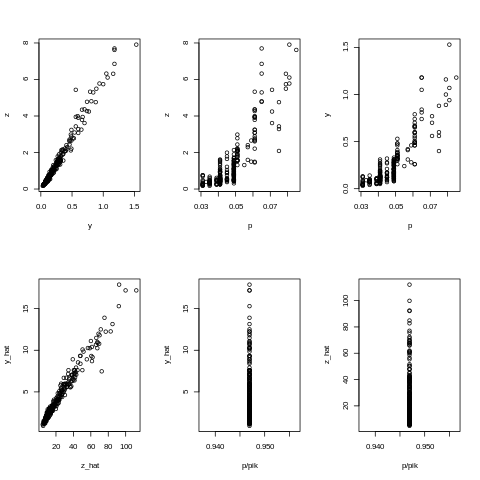

In [ ]:
%%R
####################
### Getting Data ###
####################
library(sampling)
#MU284 Sweden
data(MU284)
MU284 = MU284[MU284$P85<200,]
y5 = MU284$RMT85
x5 = MU284$P85/100
g5 = MU284$P75/100
v5 = MU284$S82/1000
h5 = MU284$ME84/1000
w5 = MU284$REV84


RMT85 = MU284$RMT85
P85 = MU284$P85/100
P75 = MU284$P75/100
S82 = MU284$S82/1000
ME84 = MU284$ME84/1000
REV84 = MU284$REV84
REG = MU284$REG


N = length(REV84)
n_percent = .05
n = round(n_percent * N)
r <- runif(N, .1, .8)
e <- rep (1, N)

#1 Great
y <- P85; z <- ME84; p <- REV84
y <- P85; z <- ME84; p <- S82
#y <- P85; z <- ME84; p <- REG
#y <- P85; z <- ME84; p <- e


pik <- inclusionprobabilities(p, n)
pik[pik>1] = 1
pik[pik==0] = 1e-4

print(c(N, n))

##########################
### Variance of Rivals ###
##########################
pikl_sys = UPsystematicpi2(pik)
pikl_max = UPmaxentropypi2(pik)
#pikl_max = pikl_sys
pikl_mid = UPmidzunopi2(pik)
pikl_til = UPtillepi2(pik)

z_hat = z / pik

var__sys <- t(z_hat) %*% (pikl_sys - (pik %*% t(pik))) %*% z_hat
var__max <- t(z_hat) %*% (pikl_max - (pik %*% t(pik))) %*% z_hat
var__mid <- t(z_hat) %*% (pikl_mid - (pik %*% t(pik))) %*% z_hat
var__til <- t(z_hat) %*% (pikl_til - (pik %*% t(pik))) %*% z_hat
var__srs <- (N**2)*(1-n/N)*(1/n)*var(z)

y_hat = y/pik

var__sys_y <- t(y_hat) %*% (pikl_sys - (pik %*% t(pik))) %*% y_hat
var__max_y <- t(y_hat) %*% (pikl_max - (pik %*% t(pik))) %*% y_hat
var__mid_y <- t(y_hat) %*% (pikl_mid - (pik %*% t(pik))) %*% y_hat
var__til_y <- t(y_hat) %*% (pikl_til - (pik %*% t(pik))) %*% y_hat
var__srs_y <- (N**2)*(1-n/N)*(1/n)*var(y)




var_x = c(var__sys, var__max, var__mid, var__til, var__srs)
names(var_x) = c('sysxy', 'maxxy', 'midxy', 'tilxy', 'srsxy')
threshold_x = min(var_x[var_x>0])

var_y = c(var__sys_y, var__max_y, var__mid_y, var__til_y, var__srs_y )
names(var_y) = c('sysy', 'maxy', 'midy', 'tily', 'srsy')
threshold_y = min(var_y[var_y>0])



#################################
############ Plots and Prints ###
#################################
par(mfrow=c(2,3))
#cat('x,y', cor(x,y), '\n x,z', cor(z, x), '\n y,z', cor(z, y), "\n")
z_hat = z/pik
print(var_x)
print(var_y)
cat("x threshold", threshold_x, "\n", "y threshold", threshold_y, "\n")
plot(y, z)
plot(p,z)
plot(p,y)

plot(z_hat,y_hat)
plot(p/pik,y_hat)

plot(p/pik,z_hat)


#cat("x_NHT, y_NHT", cor(p/pik,y/pik), "x, z", cor(x,z), "z_NHT, y_NHT", cor(z/pik,y/pik))
Final_result = cbind(y,z, y_hat, z_hat, pik, abs((y_hat- z_hat)/y_hat))



# 4. Run Fast

In [ ]:
y = np.array(ro.r['y'])
n = np.array(ro.r['n'])
N = np.array(ro.r['N'])
inclusionss = ro.r['pik']
shifted_x   = ro.r['z']
threshold_x = ro.r['threshold_x']
threshold_y = ro.r['threshold_y']

inclusions = np.array(inclusionss)

x = np.array(shifted_x)




#RaDesign = randomSearchOptimal(x=x, y=y, inclusions=inclusions, threshold_x=.7*threshold_x, threshold_y=threshold_y)
#AsDesign = AStarFast(x=x, y=y, inclusions=inclusions)
#threshold = min (.4 * np.array([threshold1, threshold2]))
#print('threshold', threshold1, threshold2, threshold)
# max_iterations, num_new_nodes, max_open_set_size, num_changes, switch_coefficient, x_efficiency, show_results = 500, 15, 10000, 10, 1, .04, 1
# AsDesign = AStarFast(x=x, y=y, inclusions=inclusions, threshold_x=threshold_x, threshold_y=threshold_y)
# AsDesign.run_AStar(max_iterations, num_new_nodes, max_open_set_size, num_changes,  switch_coefficient, x_efficiency, show_results)
# AsDesign = AStarFast(x=x, y=y, inclusions=inclusions, threshold_x=threshold_x, threshold_y=threshold_y)
# AsDesign.run_random(max_iterations, num_new_nodes, num_changes, x_efficiency, switch_coefficient)

# Simu The best

[1] 281  14
    sysxy     maxxy     midxy     tilxy     srsxy 
 8650.577  8960.066  8729.723  8941.482 30588.736 
      sysy       maxy       midy       tily       srsy 
  1.759002   2.428965   2.435588   2.429384 310.913749 
x threshold 8650.577 
 y threshold 1.759002 
[1] 281  14


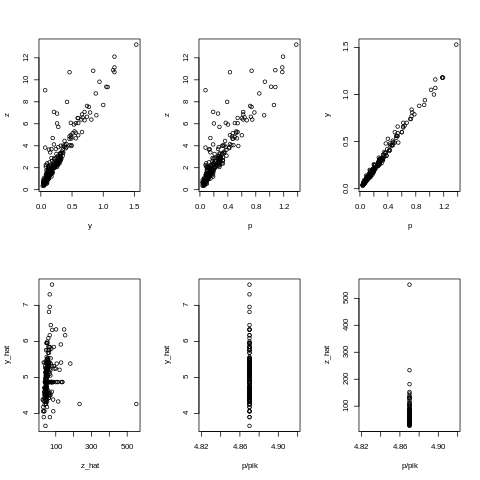

In [ ]:
%%R
####################
### Getting Data ###
####################
library(sampling)
#MU284 Sweden
data(MU284)
MU284 = MU284[MU284$P85<200,]
set.seed(121)
MU284 = MU284[sample(length(MU284[,1])),]
y5 = MU284$RMT85
x5 = MU284$P85/100
g5 = MU284$P75/100
v5 = MU284$S82/1000
h5 = MU284$ME84/1000
w5 = MU284$REV84/1000


RMT85 = MU284$RMT85
P85 = MU284$P85/100
P75 = MU284$P75/100
S82 = MU284$S82/1000
ME84 = MU284$ME84/1000
REV84 = MU284$REV84/1000
REG = MU284$REG


N = length(REV84)
n_percent = .05
n = round(n_percent * N)
r <- runif(N, .1, .8)
e <- rep (1, N)

#1 Great
y <- P85; z <- REV84; p <- P75
#y <- P85; z <- ME84; p <- S82
#y <- P85; z <- ME84; p <- REG
#y <- P85; z <- ME84; p <- e


pik <- inclusionprobabilities(p, n)
pik[pik>1] = 1
pik[pik==0] = 1e-4

print(c(N, n))

##########################
### Variance of Rivals ###
##########################
pikl_sys = UPsystematicpi2(pik)
pikl_max = UPmaxentropypi2(pik)
#pikl_max = pikl_sys
pikl_mid = UPmidzunopi2(pik)
pikl_til = UPtillepi2(pik)

z_hat = z / pik

var__sys <- t(z_hat) %*% (pikl_sys - (pik %*% t(pik))) %*% z_hat
var__max <- t(z_hat) %*% (pikl_max - (pik %*% t(pik))) %*% z_hat
var__mid <- t(z_hat) %*% (pikl_mid - (pik %*% t(pik))) %*% z_hat
var__til <- t(z_hat) %*% (pikl_til - (pik %*% t(pik))) %*% z_hat
var__srs <- (N**2)*(1-n/N)*(1/n)*var(z)

y_hat = y/pik

var__sys_y <- t(y_hat) %*% (pikl_sys - (pik %*% t(pik))) %*% y_hat
var__max_y <- t(y_hat) %*% (pikl_max - (pik %*% t(pik))) %*% y_hat
var__mid_y <- t(y_hat) %*% (pikl_mid - (pik %*% t(pik))) %*% y_hat
var__til_y <- t(y_hat) %*% (pikl_til - (pik %*% t(pik))) %*% y_hat
var__srs_y <- (N**2)*(1-n/N)*(1/n)*var(y)




var_x = c(var__sys, var__max, var__mid, var__til, var__srs)
names(var_x) = c('sysxy', 'maxxy', 'midxy', 'tilxy', 'srsxy')
threshold_x = min(var_x[var_x>0])

var_y = c(var__sys_y, var__max_y, var__mid_y, var__til_y, var__srs_y )
names(var_y) = c('sysy', 'maxy', 'midy', 'tily', 'srsy')
threshold_y = min(var_y[var_y>0])



#################################
############ Plots and Prints ###
#################################
par(mfrow=c(2,3))
#cat('x,y', cor(x,y), '\n x,z', cor(z, x), '\n y,z', cor(z, y), "\n")
z_hat = z/pik
print(var_x)
print(var_y)
cat("x threshold", threshold_x, "\n", "y threshold", threshold_y, "\n")
plot(y, z)
plot(p,z)
plot(p,y)

plot(z_hat,y_hat)
plot(p/pik,y_hat)

plot(p/pik,z_hat)


#cat("x_NHT, y_NHT", cor(p/pik,y/pik), "x, z", cor(x,z), "z_NHT, y_NHT", cor(z/pik,y/pik))
Final_result = cbind(y,z, y_hat, z_hat, pik, abs((y_hat- z_hat)/y_hat))

print(c(N,n))

In [ ]:
y = np.array(ro.r['y'])
n = np.array(ro.r['n'])
N = np.array(ro.r['N'])
inclusionss = ro.r['pik']
shifted_x   = ro.r['z']
threshold_x = ro.r['threshold_x']
threshold_y = ro.r['threshold_y']
inclusions = np.array(inclusionss)
x = np.array(shifted_x)



max_open_set_size, switch_coefficient, x_efficiency = 200000,  1, .04
show_results = 0
random = 0
max_iterations = 500

for num_changes in [1]:
      for num_new_nodes in [5,10,20,40]:
            print(max_iterations, num_new_nodes, max_open_set_size, num_changes, switch_coefficient, x_efficiency)
            if random == 1:
                AsDesign = AStarFast(x=x, y=y, inclusions=inclusions, threshold_x=threshold_x, threshold_y=threshold_y)
                AsDesign.run_random(max_iterations, num_new_nodes,  num_changes, switch_coefficient, x_efficiency)
            AsDesign = AStarFast(x=x, y=y, inclusions=inclusions, threshold_x=threshold_x, threshold_y=threshold_y)
            AsDesign.run_AStar(max_iterations, num_new_nodes, max_open_set_size, num_changes, switch_coefficient, x_efficiency, show_results)

500 5 200000 1 1 0.04
1.0 AStar NHT_corr 0.025 
 0eff_x [1.] feff_x [1.692] 0eff_y [1.] feff_y [0.9594] 
eff_coeff 0.04 alpha 1 deep 496 D 427
500 10 200000 1 1 0.04
1.0 AStar NHT_corr -0.209 
 0eff_x [1.] feff_x [2.386] 0eff_y [1.] feff_y [0.8027] 
eff_coeff 0.04 alpha 1 deep 499 D 423
500 20 200000 1 1 0.04
1.0 AStar NHT_corr -0.31 
 0eff_x [1.] feff_x [3.209] 0eff_y [1.] feff_y [0.8262] 
eff_coeff 0.04 alpha 1 deep 500 D 420
500 40 200000 1 1 0.04
1.0 AStar NHT_corr -0.4 
 0eff_x [1.] feff_x [3.941] 0eff_y [1.] feff_y [0.6926] 
eff_coeff 0.04 alpha 1 deep 500 D 409


# Simu Medium

[1] 281  14
    sysxy     maxxy     midxy     tilxy     srsxy 
 5346.133  6024.473  5085.605  6000.730 11520.910 
    sysy     maxy     midy     tily     srsy 
135.5725 154.9205 130.9164 154.2952 310.9137 
x threshold 5085.605 
 y threshold 130.9164 


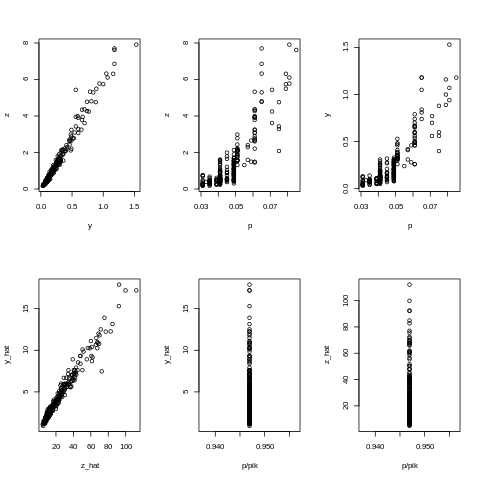

In [ ]:
%%R
####################
### Getting Data ###
####################
library(sampling)
#MU284 Sweden
data(MU284)
set.seed(121)
MU284 = MU284[MU284$P85<200,]
MU284 = MU284[sample(length(MU284[,1])),]

y5 = MU284$RMT85
x5 = MU284$P85/100
g5 = MU284$P75/100
v5 = MU284$S82/1000
h5 = MU284$ME84/1000
w5 = MU284$REV84


RMT85 = MU284$RMT85
P85 = MU284$P85/100
P75 = MU284$P75/100
S82 = MU284$S82/1000
ME84 = MU284$ME84/1000
REV84 = MU284$REV84/1000
REG = MU284$REG


N = length(REV84)
n_percent = .05
n = round(n_percent * N)
r <- runif(N, .1, .8)
e <- rep (1, N)

#1 Great
y <- P85; z <- ME84; p <- REV84
y <- P85; z <- ME84; p <- S82
#y <- P85; z <- ME84; p <- REG
#y <- P85; z <- ME84; p <- e


pik <- inclusionprobabilities(p, n)
pik[pik>1] = 1
pik[pik==0] = 1e-4

print(c(N, n))

##########################
### Variance of Rivals ###
##########################
pikl_sys = UPsystematicpi2(pik)
pikl_max = UPmaxentropypi2(pik)
#pikl_max = pikl_sys
pikl_mid = UPmidzunopi2(pik)
pikl_til = UPtillepi2(pik)

z_hat = z / pik

var__sys <- t(z_hat) %*% (pikl_sys - (pik %*% t(pik))) %*% z_hat
var__max <- t(z_hat) %*% (pikl_max - (pik %*% t(pik))) %*% z_hat
var__mid <- t(z_hat) %*% (pikl_mid - (pik %*% t(pik))) %*% z_hat
var__til <- t(z_hat) %*% (pikl_til - (pik %*% t(pik))) %*% z_hat
var__srs <- (N**2)*(1-n/N)*(1/n)*var(z)

y_hat = y/pik

var__sys_y <- t(y_hat) %*% (pikl_sys - (pik %*% t(pik))) %*% y_hat
var__max_y <- t(y_hat) %*% (pikl_max - (pik %*% t(pik))) %*% y_hat
var__mid_y <- t(y_hat) %*% (pikl_mid - (pik %*% t(pik))) %*% y_hat
var__til_y <- t(y_hat) %*% (pikl_til - (pik %*% t(pik))) %*% y_hat
var__srs_y <- (N**2)*(1-n/N)*(1/n)*var(y)




var_x = c(var__sys, var__max, var__mid, var__til, var__srs)
names(var_x) = c('sysxy', 'maxxy', 'midxy', 'tilxy', 'srsxy')
threshold_x = min(var_x[var_x>0])

var_y = c(var__sys_y, var__max_y, var__mid_y, var__til_y, var__srs_y )
names(var_y) = c('sysy', 'maxy', 'midy', 'tily', 'srsy')
threshold_y = min(var_y[var_y>0])



#################################
############ Plots and Prints ###
#################################
par(mfrow=c(2,3))
#cat('x,y', cor(x,y), '\n x,z', cor(z, x), '\n y,z', cor(z, y), "\n")
z_hat = z/pik
print(var_x)
print(var_y)
cat("x threshold", threshold_x, "\n", "y threshold", threshold_y, "\n")
plot(y, z)
plot(p,z)
plot(p,y)

plot(z_hat,y_hat)
plot(p/pik,y_hat)

plot(p/pik,z_hat)


#cat("x_NHT, y_NHT", cor(p/pik,y/pik), "x, z", cor(x,z), "z_NHT, y_NHT", cor(z/pik,y/pik))
Final_result = cbind(y,z, y_hat, z_hat, pik, abs((y_hat- z_hat)/y_hat))



In [ ]:
y = np.array(ro.r['y'])
n = np.array(ro.r['n'])
N = np.array(ro.r['N'])
inclusionss = ro.r['pik']
shifted_x   = ro.r['z']
threshold_x = ro.r['threshold_x']
threshold_y = ro.r['threshold_y']
inclusions = np.array(inclusionss)
x = np.array(shifted_x)





max_open_set_size, switch_coefficient, x_efficiency = 20000,  1, .04
show_results = 0
random = 0
max_iterations = 500

for num_changes in [1]:
      for num_new_nodes in [5,10,20,40]:
            print(max_iterations, num_new_nodes, max_open_set_size, num_changes, switch_coefficient, x_efficiency)
            if random == 1:
                AsDesign = AStarFast(x=x, y=y, inclusions=inclusions, threshold_x=threshold_x, threshold_y=threshold_y)
                AsDesign.run_random(max_iterations, num_new_nodes,  num_changes, switch_coefficient, x_efficiency)
            AsDesign = AStarFast(x=x, y=y, inclusions=inclusions, threshold_x=threshold_x, threshold_y=threshold_y)
            AsDesign.run_AStar(max_iterations, num_new_nodes, max_open_set_size, num_changes, switch_coefficient, x_efficiency, show_results)

500 5 20000 1 1 0.04
1.0 AStar NHT_corr 0.976 
 0eff_x [0.951] feff_x [1.697] 0eff_y [0.966] feff_y [1.7092] 
eff_coeff 0.04 alpha 1 deep 495 D 765
500 10 20000 1 1 0.04
1.0 AStar NHT_corr 0.965 
 0eff_x [0.951] feff_x [2.91] 0eff_y [0.966] feff_y [2.7096] 
eff_coeff 0.04 alpha 1 deep 499 D 774
500 20 20000 1 1 0.04
1.0 AStar NHT_corr 0.952 
 0eff_x [0.951] feff_x [4.554] 0eff_y [0.966] feff_y [4.1253] 
eff_coeff 0.04 alpha 1 deep 500 D 769
500 40 20000 1 1 0.04
1.0 AStar NHT_corr 0.921 
 0eff_x [0.951] feff_x [10.38] 0eff_y [0.966] feff_y [8.1052] 
eff_coeff 0.04 alpha 1 deep 500 D 765


# Simu random

[1] 281  14
    sysxy     maxxy     midxy     tilxy     srsxy 
104847.56  81960.38  76469.94  81184.72  30588.74 
     sysy      maxy      midy      tily      srsy 
1066.4648  815.2965  761.7397  808.1434  310.9137 
x threshold 30588.74 
 y threshold 310.9137 


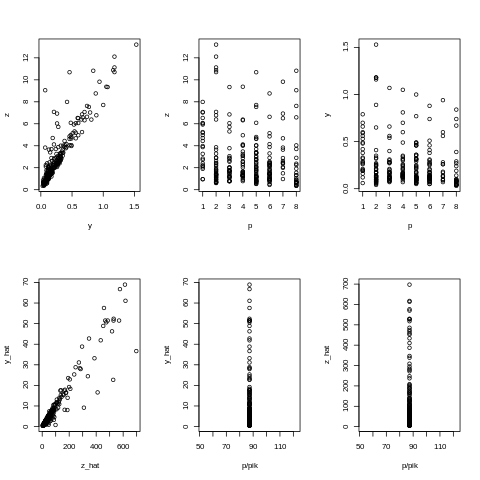

In [ ]:
%%R
####################
### Getting Data ###
####################
library(sampling)
#MU284 Sweden
data(MU284)
set.seed(121)
MU284 = MU284[MU284$P85<200,]
MU284 = MU284[sample(length(MU284[,1])),]

y5 = MU284$RMT85
x5 = MU284$P85/100
g5 = MU284$P75/100
v5 = MU284$S82/1000
h5 = MU284$ME84/1000
w5 = MU284$REV84


RMT85 = MU284$RMT85
P85 = MU284$P85/100
P75 = MU284$P75/100
S82 = MU284$S82/1000
ME84 = MU284$ME84/1000
REV84 = MU284$REV84/1000
REG = MU284$REG


N = length(REV84)
n_percent = .05
n = round(n_percent * N)
r <- runif(N, .1, .8)
e <- rep (1, N)

#1 Great
y <- P85; z <- ME84; p <- REV84
y <- P85; z <- ME84; p <- S82
y <- P85; z <- REV84; p <- REG
#y <- P85; z <- ME84; p <- e


pik <- inclusionprobabilities(p, n)
pik[pik>1] = 1
pik[pik==0] = 1e-4

print(c(N, n))

##########################
### Variance of Rivals ###
##########################
pikl_sys = UPsystematicpi2(pik)
pikl_max = UPmaxentropypi2(pik)
#pikl_max = pikl_sys
pikl_mid = UPmidzunopi2(pik)
pikl_til = UPtillepi2(pik)

z_hat = z / pik

var__sys <- t(z_hat) %*% (pikl_sys - (pik %*% t(pik))) %*% z_hat
var__max <- t(z_hat) %*% (pikl_max - (pik %*% t(pik))) %*% z_hat
var__mid <- t(z_hat) %*% (pikl_mid - (pik %*% t(pik))) %*% z_hat
var__til <- t(z_hat) %*% (pikl_til - (pik %*% t(pik))) %*% z_hat
var__srs <- (N**2)*(1-n/N)*(1/n)*var(z)

y_hat = y/pik

var__sys_y <- t(y_hat) %*% (pikl_sys - (pik %*% t(pik))) %*% y_hat
var__max_y <- t(y_hat) %*% (pikl_max - (pik %*% t(pik))) %*% y_hat
var__mid_y <- t(y_hat) %*% (pikl_mid - (pik %*% t(pik))) %*% y_hat
var__til_y <- t(y_hat) %*% (pikl_til - (pik %*% t(pik))) %*% y_hat
var__srs_y <- (N**2)*(1-n/N)*(1/n)*var(y)




var_x = c(var__sys, var__max, var__mid, var__til, var__srs)
names(var_x) = c('sysxy', 'maxxy', 'midxy', 'tilxy', 'srsxy')
threshold_x = min(var_x[var_x>0])

var_y = c(var__sys_y, var__max_y, var__mid_y, var__til_y, var__srs_y )
names(var_y) = c('sysy', 'maxy', 'midy', 'tily', 'srsy')
threshold_y = min(var_y[var_y>0])



#################################
############ Plots and Prints ###
#################################
par(mfrow=c(2,3))
#cat('x,y', cor(x,y), '\n x,z', cor(z, x), '\n y,z', cor(z, y), "\n")
z_hat = z/pik
print(var_x)
print(var_y)
cat("x threshold", threshold_x, "\n", "y threshold", threshold_y, "\n")
plot(y, z)
plot(p,z)
plot(p,y)

plot(z_hat,y_hat)
plot(p/pik,y_hat)

plot(p/pik,z_hat)


#cat("x_NHT, y_NHT", cor(p/pik,y/pik), "x, z", cor(x,z), "z_NHT, y_NHT", cor(z/pik,y/pik))
Final_result = cbind(y,z, y_hat, z_hat, pik, abs((y_hat- z_hat)/y_hat))



In [ ]:
y = np.array(ro.r['y'])
n = np.array(ro.r['n'])
N = np.array(ro.r['N'])
inclusionss = ro.r['pik']
shifted_x   = ro.r['z']
threshold_x = ro.r['threshold_x']
threshold_y = ro.r['threshold_y']
inclusions = np.array(inclusionss)
x = np.array(shifted_x)





max_open_set_size, switch_coefficient, x_efficiency = 200000,  1, .04
show_results = 1
random = 0
max_iterations = 50000

for num_changes in [1]:
      for num_new_nodes in [ 40]:
            print(max_iterations, num_new_nodes, max_open_set_size, num_changes, switch_coefficient, x_efficiency)
            if random == 1:
                AsDesign = AStarFast(x=x, y=y, inclusions=inclusions, threshold_x=threshold_x, threshold_y=threshold_y)
                AsDesign.run_random(max_iterations, num_new_nodes,  num_changes, switch_coefficient, x_efficiency)
            AsDesign = AStarFast(x=x, y=y, inclusions=inclusions, threshold_x=threshold_x, threshold_y=threshold_y)
            AsDesign.run_AStar(max_iterations, num_new_nodes, max_open_set_size, num_changes, switch_coefficient, x_efficiency, show_results)

Streaming output truncated to the last 5000 lines.
 0eff_x [0.292] feff_x [285.683] 0eff_y [0.292] feff_y [4.0562] 
eff_coeff 0.04 alpha 1 deep 3361 D 1551
0.06724 NHT_corr 0.113 
 0eff_x [0.292] feff_x [285.683] 0eff_y [0.292] feff_y [4.0562] 
eff_coeff 0.04 alpha 1 deep 3362 D 1551
0.06726 NHT_corr 0.113 
 0eff_x [0.292] feff_x [285.683] 0eff_y [0.292] feff_y [4.0562] 
eff_coeff 0.04 alpha 1 deep 3363 D 1551
NHT_corr 0.113 
 0eff_x [0.292] feff_x [285.827] 0eff_y [0.292] feff_y [4.0523] 
eff_coeff 0.04 alpha 1 deep 3363 D 1552
0.06728 NHT_corr 0.114 
 0eff_x [0.292] feff_x [285.827] 0eff_y [0.292] feff_y [4.0523] 
eff_coeff 0.04 alpha 1 deep 3364 D 1553
NHT_corr 0.114 
 0eff_x [0.292] feff_x [285.827] 0eff_y [0.292] feff_y [4.0523] 
eff_coeff 0.04 alpha 1 deep 3364 D 1552
0.0673 NHT_corr 0.113 
 0eff_x [0.292] feff_x [285.827] 0eff_y [0.292] feff_y [4.0523] 
eff_coeff 0.04 alpha 1 deep 3365 D 1553
NHT_corr 0.114 
 0eff_x [0.292] feff_x [286.596] 0eff_y [0.292] feff_y [4.0556] 
eff_co

KeyboardInterrupt: 

# Simu equal

[1] 281  14
   sysxy    maxxy    midxy    tilxy    srsxy 
18801.40 30588.74 30588.74 30588.74 30588.74 
    sysy     maxy     midy     tily     srsy 
200.6385 310.9137 310.9137 310.9137 310.9137 
x threshold 18801.4 
 y threshold 200.6385 
[1] 0.8769034
[1] 0.7661379


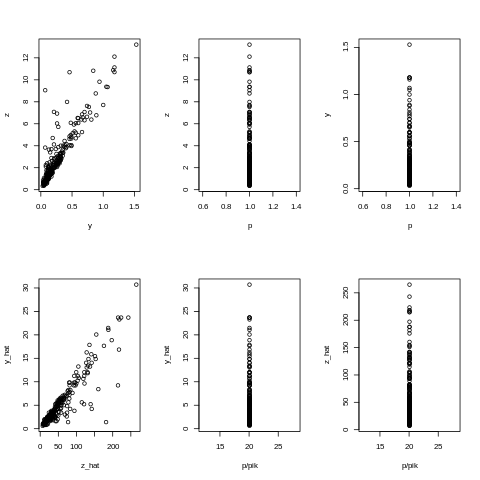

In [ ]:
%%R
####################
### Getting Data ###
####################
library(sampling)
#MU284 Sweden
data(MU284)
set.seed(121)
MU284 = MU284[MU284$P85<200,]
MU284 = MU284[sample(length(MU284[,1])),]

y5 = MU284$RMT85
x5 = MU284$P85/100
g5 = MU284$P75/100
v5 = MU284$S82/1000
h5 = MU284$ME84/1000
w5 = MU284$REV84


RMT85 = MU284$RMT85
P85 = MU284$P85/100
P75 = MU284$P75/100
S82 = MU284$S82/1000
ME84 = MU284$ME84/1000
REV84 = MU284$REV84/1000
REG = MU284$REG


N = length(REV84)
n_percent = .05
n = round(n_percent * N)
r <- runif(N, .1, .8)
e <- rep (1, N)

#1 Great
y <- P85; z <- ME84; p <- REV84
y <- P85; z <- ME84; p <- S82
y <- P85; z <- ME84; p <- REG
y <- P85; z <- REV84; p <- e


pik <- inclusionprobabilities(p, n)
pik[pik>1] = 1
pik[pik==0] = 1e-4

print(c(N, n))

##########################
### Variance of Rivals ###
##########################
pikl_sys = UPsystematicpi2(pik)
pikl_max = UPmaxentropypi2(pik)
#pikl_max = pikl_sys
pikl_mid = UPmidzunopi2(pik)
pikl_til = UPtillepi2(pik)

z_hat = z / pik

var__sys <- t(z_hat) %*% (pikl_sys - (pik %*% t(pik))) %*% z_hat
var__max <- t(z_hat) %*% (pikl_max - (pik %*% t(pik))) %*% z_hat
var__mid <- t(z_hat) %*% (pikl_mid - (pik %*% t(pik))) %*% z_hat
var__til <- t(z_hat) %*% (pikl_til - (pik %*% t(pik))) %*% z_hat
var__srs <- (N**2)*(1-n/N)*(1/n)*var(z)

y_hat = y/pik

var__sys_y <- t(y_hat) %*% (pikl_sys - (pik %*% t(pik))) %*% y_hat
var__max_y <- t(y_hat) %*% (pikl_max - (pik %*% t(pik))) %*% y_hat
var__mid_y <- t(y_hat) %*% (pikl_mid - (pik %*% t(pik))) %*% y_hat
var__til_y <- t(y_hat) %*% (pikl_til - (pik %*% t(pik))) %*% y_hat
var__srs_y <- (N**2)*(1-n/N)*(1/n)*var(y)




var_x = c(var__sys, var__max, var__mid, var__til, var__srs)
names(var_x) = c('sysxy', 'maxxy', 'midxy', 'tilxy', 'srsxy')
threshold_x = min(var_x[var_x>0])

var_y = c(var__sys_y, var__max_y, var__mid_y, var__til_y, var__srs_y )
names(var_y) = c('sysy', 'maxy', 'midy', 'tily', 'srsy')
threshold_y = min(var_y[var_y>0])



#################################
############ Plots and Prints ###
#################################
par(mfrow=c(2,3))
#cat('x,y', cor(x,y), '\n x,z', cor(z, x), '\n y,z', cor(z, y), "\n")
z_hat = z/pik
print(var_x)
print(var_y)
cat("x threshold", threshold_x, "\n", "y threshold", threshold_y, "\n")
plot(y, z)
plot(p,z)
plot(p,y)

plot(z_hat,y_hat)
plot(p/pik,y_hat)

plot(p/pik,z_hat)


#cat("x_NHT, y_NHT", cor(p/pik,y/pik), "x, z", cor(x,z), "z_NHT, y_NHT", cor(z/pik,y/pik))
Final_result = cbind(y,z, y_hat, z_hat, pik, abs((y_hat- z_hat)/y_hat))
print(1/(34882676019/30588735669))
print(1/(405.8195/310.9137))

In [ ]:
y = np.array(ro.r['y'])
n = np.array(ro.r['n'])
N = np.array(ro.r['N'])
inclusionss = ro.r['pik']
shifted_x   = ro.r['z']
threshold_x = ro.r['threshold_x']
threshold_y = ro.r['threshold_y']
inclusions = np.array(inclusionss)
x = np.array(shifted_x)





max_open_set_size, switch_coefficient, x_efficiency = 20000,  1, .04
show_results = 0
random = 0
max_iterations = 500

for num_changes in [1]:
      for num_new_nodes in [5,10,20,40]:
            print(max_iterations, num_new_nodes, max_open_set_size, num_changes, switch_coefficient, x_efficiency)
            if random == 1:
                AsDesign = AStarFast(x=x, y=y, inclusions=inclusions, threshold_x=threshold_x, threshold_y=threshold_y)
                AsDesign.run_random(max_iterations, num_new_nodes,  num_changes, switch_coefficient, x_efficiency)
            AsDesign = AStarFast(x=x, y=y, inclusions=inclusions, threshold_x=threshold_x, threshold_y=threshold_y)
            AsDesign.run_AStar(max_iterations, num_new_nodes, max_open_set_size, num_changes, switch_coefficient, x_efficiency, show_results),

500 5 20000 1 1 0.04
1.0 AStar NHT_corr 0.697 
 0eff_x [1.] feff_x [5.068] 0eff_y [1.] feff_y [2.369] 
eff_coeff 0.04 alpha 1 deep 491 D 281
500 10 20000 1 1 0.04
1.0 AStar NHT_corr 0.527 
 0eff_x [1.] feff_x [13.707] 0eff_y [1.] feff_y [3.3326] 
eff_coeff 0.04 alpha 1 deep 499 D 281
500 20 20000 1 1 0.04
1.0 AStar NHT_corr 0.285 
 0eff_x [1.] feff_x [64.347] 0eff_y [1.] feff_y [4.2206] 
eff_coeff 0.04 alpha 1 deep 500 D 281
500 40 20000 1 1 0.04
1.0 AStar NHT_corr 0.071 
 0eff_x [1.] feff_x [188.606] 0eff_y [1.] feff_y [4.3056] 
eff_coeff 0.04 alpha 1 deep 499 D 281


# plot

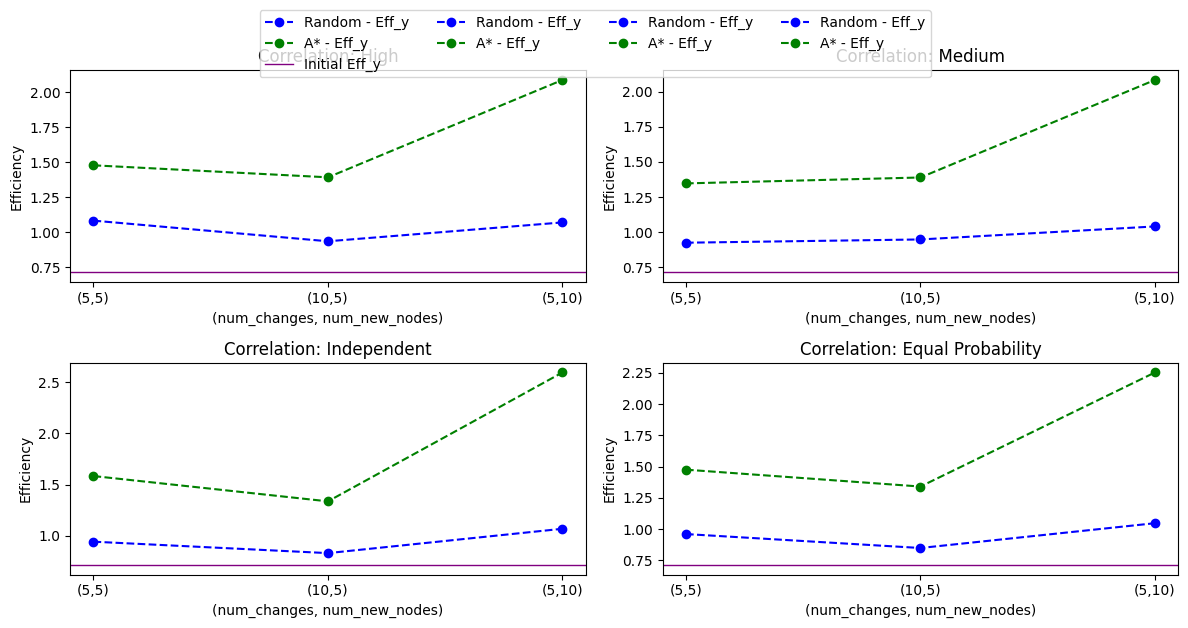

In [ ]:
import matplotlib.pyplot as plt

# Define data
correlations = ['High', 'Medium', 'Independent', 'Equal Probability']
configurations = ['(5,5)', '(10,5)', '(5,10)']
initial_eff_x, initial_eff_y = 0.687, 0.714  # Initial efficiency baseline values

random_eff_x_y = {
    'High': [(1.059, 1.0844), (0.905, 0.9368), (1.056, 1.0715)],
    'Medium': [(0.887, 0.9255), (0.924, 0.9486), (1.002, 1.0411)],
    'Independent': [(0.933, 0.9415), (0.799, 0.8297), (1.047, 1.0677)],
    'Equal Probability': [(0.926, 0.9608), (0.838, 0.8495), (1.01, 1.0476)],
}

astar_eff_x_y = {
    'High': [(1.489, 1.4796), (1.388, 1.3938), (2.12, 2.0895)],
    'Medium': [(1.324, 1.3471), (1.364, 1.3891), (2.104, 2.0824)],
    'Independent': [(1.572, 1.583), (1.332, 1.3357), (2.514, 2.5954)],
    'Equal Probability': [(1.458, 1.4753), (1.335, 1.3405), (2.246, 2.252)],
}

# Plot
fig, axs = plt.subplots(2, 2, figsize=(12, 6))
axs = axs.flatten()

for i, correlation in enumerate(correlations):
    # Extract random and A* values for current correlation
    random_values = random_eff_x_y[correlation]
    astar_values = astar_eff_x_y[correlation]

    # Separate x and y values for plotting
    random_x, random_y = zip(*random_values)
    astar_x, astar_y = zip(*astar_values)

    # Plot random and A* values
    #axs[i].plot(configurations, random_x, marker='o', color='blue', label='Random - Eff_x')
    axs[i].plot(configurations, random_y, marker='o', linestyle='--', color='blue', label='Random - Eff_y')
    #axs[i].plot(configurations, astar_x, marker='o', color='green', label='A* - Eff_x')
    axs[i].plot(configurations, astar_y, marker='o', linestyle='--', color='green', label='A* - Eff_y')

    # Add horizontal lines for baseline efficiencies
    #axs[i].axhline(initial_eff_x, color='red', linestyle='-', linewidth=1, label='Initial Eff_x' if i == 0 else "")
    axs[i].axhline(initial_eff_y, color='purple', linestyle='-', linewidth=1, label='Initial Eff_y' if i == 0 else "")

    # Set plot title and labels
    axs[i].set_title(f'Correlation: {correlation}')
    axs[i].set_xlabel('(num_changes, num_new_nodes)')
    axs[i].set_ylabel('Efficiency')

# Adjust layout and show legend
fig.legend(loc="upper center", bbox_to_anchor=(0.5, 1.05), ncol=4)
plt.tight_layout()
plt.show()

In [ ]:
import pandas as pd

# Define the data
data = {
    'Category': ['High', 'High', 'High', 'High', 'Medium', 'Medium', 'Medium', 'Medium', 'Random', 'Random', 'Random', 'Random', 'Equal', 'Equal', 'Equal', 'Equal',
                 'High (Rev Me)', 'High (Rev Me)', 'High (Rev Me)', 'High (Rev Me)', 'Medium (Rev Me)', 'Medium (Rev Me)', 'Medium (Rev Me)', 'Medium (Rev Me)',
                 'Random (Rev Me)', 'Random (Rev Me)', 'Random (Rev Me)', 'Random (Rev Me)', 'Equal (Rev Me)', 'Equal (Rev Me)', 'Equal (Rev Me)', 'Equal (Rev Me)'],
    'Iteration': [500] * 32,
    'num_new_node': [5, 10, 20, 40, 5, 10, 20, 40, 5, 10, 20, 40, 5, 10, 20, 40, 5, 10, 20, 40, 5, 10, 20, 40, 5, 10, 20, 40, 5, 10, 20, 40],
    'max_open_set': [20000] * 32,
    'num_changes': [1] * 32,
    'switch': [1] * 32,
    'nothing': [0.04] * 32,
    '0eff_x': [0.653, 0.653, 0.653, 0.653, 0.857, 0.857, 0.857, 0.857, 0.393, 0.393, 0.393, 0.393, 1.0, 1.0, 1.0, 1.0, 0.925, 0.925, 0.925, 0.925, 1.0, 1.0, 1.0, 1.0, 0.443, 0.443, 0.443, 0.443, 1.0, 1.0, 1.0, 1.0],
    'feff_x': [2.618, 5.77, 12.247, 44.341, 1.737, 2.482, 4.788, 9.051, 0.769, 1.126, 1.634, 2.42, 5.466, 13.123, 44.719, 182.633, 1.318, 1.587, 2.074, 2.698, 1.866, 3.497, 6.362, 8.793, 0.811, 1.249, 1.826, 2.698, 5.754, 19.716, 71.68, 253.283],
    '0eff_y': [1.0, 1.0, 1.0, 1.0, 0.822, 0.822, 0.822, 0.822, 0.41, 0.41, 0.41, 0.41, 1.0, 1.0, 1.0, 1.0, 0.751, 0.751, 0.751, 0.751, 1.0, 1.0, 1.0, 1.0, 0.469, 0.469, 0.469, 0.469, 1.0, 1.0, 1.0, 1.0],
    'feff_y': [1.0859, 1.0779, 1.0992, 1.0741, 1.6119, 2.1368, 4.0569, 6.2806, 0.8074, 1.198, 1.773, 2.5734, 4.9988, 10.6638, 23.1346, 37.2102, 0.8484, 0.9169, 0.8836, 0.8251, 1.3731, 1.6325, 1.595, 1.7723, 0.7817, 1.0953, 1.3582, 1.7832, 2.6392, 3.122, 3.4801, 3.4241]
}

# Convert to DataFrame
df = pd.DataFrame(data)

# Display DataFrame
print(df)


           Category  Iteration  num_new_node  max_open_set  num_changes  \
0              High        500             5         20000            1   
1              High        500            10         20000            1   
2              High        500            20         20000            1   
3              High        500            40         20000            1   
4            Medium        500             5         20000            1   
5            Medium        500            10         20000            1   
6            Medium        500            20         20000            1   
7            Medium        500            40         20000            1   
8            Random        500             5         20000            1   
9            Random        500            10         20000            1   
10           Random        500            20         20000            1   
11           Random        500            40         20000            1   
12            Equal      

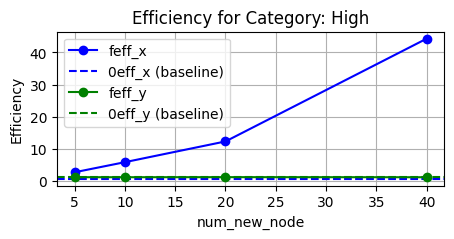

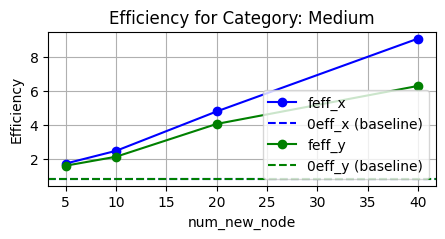

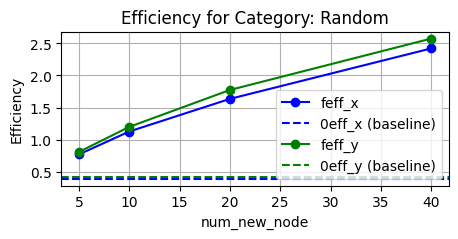

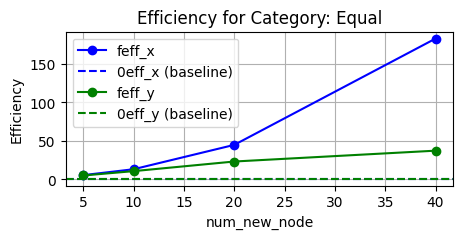

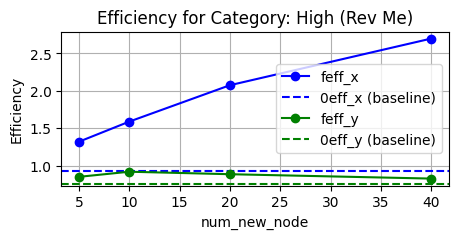

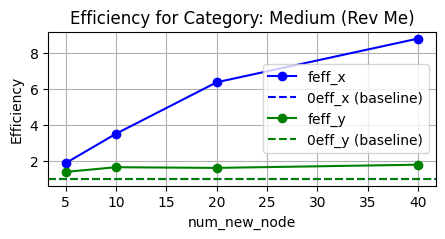

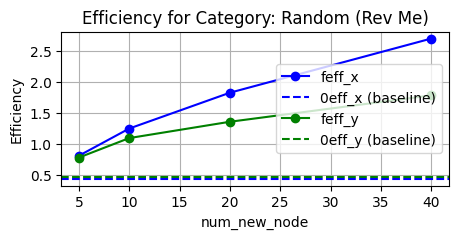

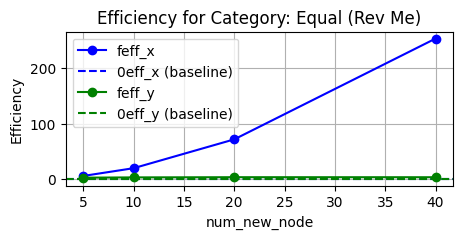

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Define the data
data = {
    'Category': ['High', 'High', 'High', 'High', 'Medium', 'Medium', 'Medium', 'Medium', 'Random', 'Random', 'Random', 'Random', 'Equal', 'Equal', 'Equal', 'Equal',
                 'High (Rev Me)', 'High (Rev Me)', 'High (Rev Me)', 'High (Rev Me)', 'Medium (Rev Me)', 'Medium (Rev Me)', 'Medium (Rev Me)', 'Medium (Rev Me)',
                 'Random (Rev Me)', 'Random (Rev Me)', 'Random (Rev Me)', 'Random (Rev Me)', 'Equal (Rev Me)', 'Equal (Rev Me)', 'Equal (Rev Me)', 'Equal (Rev Me)'],
    'Iteration': [500] * 32,
    'num_new_node': [5, 10, 20, 40, 5, 10, 20, 40, 5, 10, 20, 40, 5, 10, 20, 40, 5, 10, 20, 40, 5, 10, 20, 40, 5, 10, 20, 40, 5, 10, 20, 40],
    'max_open_set': [20000] * 32,
    'num_changes': [1] * 32,
    'switch': [1] * 32,
    'nothing': [0.04] * 32,
    '0eff_x': [0.653, 0.653, 0.653, 0.653, 0.857, 0.857, 0.857, 0.857, 0.393, 0.393, 0.393, 0.393, 1.0, 1.0, 1.0, 1.0, 0.925, 0.925, 0.925, 0.925, 1.0, 1.0, 1.0, 1.0, 0.443, 0.443, 0.443, 0.443, 1.0, 1.0, 1.0, 1.0],
    'feff_x': [2.618, 5.77, 12.247, 44.341, 1.737, 2.482, 4.788, 9.051, 0.769, 1.126, 1.634, 2.42, 5.466, 13.123, 44.719, 182.633, 1.318, 1.587, 2.074, 2.698, 1.866, 3.497, 6.362, 8.793, 0.811, 1.249, 1.826, 2.698, 5.754, 19.716, 71.68, 253.283],
    '0eff_y': [1.0, 1.0, 1.0, 1.0, 0.822, 0.822, 0.822, 0.822, 0.41, 0.41, 0.41, 0.41, 1.0, 1.0, 1.0, 1.0, 0.751, 0.751, 0.751, 0.751, 1.0, 1.0, 1.0, 1.0, 0.469, 0.469, 0.469, 0.469, 1.0, 1.0, 1.0, 1.0],
    'feff_y': [1.0859, 1.0779, 1.0992, 1.0741, 1.6119, 2.1368, 4.0569, 6.2806, 0.8074, 1.198, 1.773, 2.5734, 4.9988, 10.6638, 23.1346, 37.2102, 0.8484, 0.9169, 0.8836, 0.8251, 1.3731, 1.6325, 1.595, 1.7723, 0.7817, 1.0953, 1.3582, 1.7832, 2.6392, 3.122, 3.4801, 3.4241]
}

# Convert to DataFrame
df = pd.DataFrame(data)

# Define unique categories
categories = df['Category'].unique()

# Plotting each category as requested
for category in categories:
    subset = df[df['Category'] == category]
    plt.figure(figsize=(5, 2))

    # Plot feff_x with 0eff_x as baseline
    plt.plot(subset['num_new_node'], subset['feff_x'], marker='o', label='feff_x', color='blue')
    plt.axhline(y=subset['0eff_x'].iloc[0], color='blue', linestyle='--', label='0eff_x (baseline)')

    # Plot feff_y with 0eff_y as baseline
    plt.plot(subset['num_new_node'], subset['feff_y'], marker='o', label='feff_y', color='green')
    plt.axhline(y=subset['0eff_y'].iloc[0], color='green', linestyle='--', label='0eff_y (baseline)')

    # Plot settings
    plt.xlabel('num_new_node')
    plt.ylabel('Efficiency')
    plt.title(f'Efficiency for Category: {category}')
    plt.legend()
    plt.grid(True)

    # Show the plot
    plt.show()


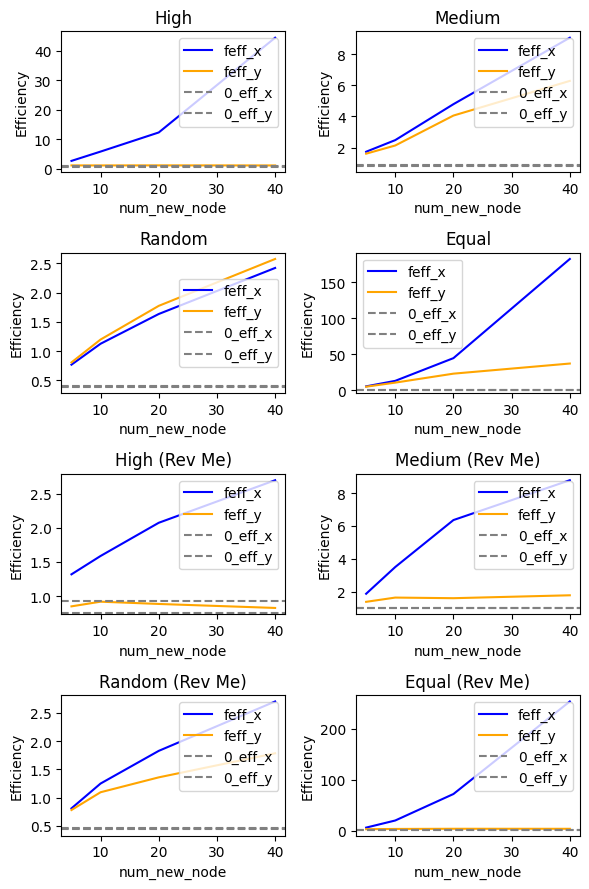

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Define the data
data = {
    'Category': ['High', 'High', 'High', 'High', 'Medium', 'Medium', 'Medium', 'Medium', 'Random', 'Random', 'Random', 'Random', 'Equal', 'Equal', 'Equal', 'Equal',
                 'High (Rev Me)', 'High (Rev Me)', 'High (Rev Me)', 'High (Rev Me)', 'Medium (Rev Me)', 'Medium (Rev Me)', 'Medium (Rev Me)', 'Medium (Rev Me)',
                 'Random (Rev Me)', 'Random (Rev Me)', 'Random (Rev Me)', 'Random (Rev Me)', 'Equal (Rev Me)', 'Equal (Rev Me)', 'Equal (Rev Me)', 'Equal (Rev Me)'],
    'Iteration': [500] * 32,
    'num_new_node': [5, 10, 20, 40, 5, 10, 20, 40, 5, 10, 20, 40, 5, 10, 20, 40, 5, 10, 20, 40, 5, 10, 20, 40, 5, 10, 20, 40, 5, 10, 20, 40],
    'max_open_set': [20000] * 32,
    'num_changes': [1] * 32,
    'switch': [1] * 32,
    'nothing': [0.04] * 32,
    '0eff_x': [0.653, 0.653, 0.653, 0.653, 0.857, 0.857, 0.857, 0.857, 0.393, 0.393, 0.393, 0.393, 1.0, 1.0, 1.0, 1.0, 0.925, 0.925, 0.925, 0.925, 1.0, 1.0, 1.0, 1.0, 0.443, 0.443, 0.443, 0.443, 1.0, 1.0, 1.0, 1.0],
    'feff_x': [2.618, 5.77, 12.247, 44.341, 1.737, 2.482, 4.788, 9.051, 0.769, 1.126, 1.634, 2.42, 5.466, 13.123, 44.719, 182.633, 1.318, 1.587, 2.074, 2.698, 1.866, 3.497, 6.362, 8.793, 0.811, 1.249, 1.826, 2.698, 5.754, 19.716, 71.68, 253.283],
    '0eff_y': [1.0, 1.0, 1.0, 1.0, 0.822, 0.822, 0.822, 0.822, 0.41, 0.41, 0.41, 0.41, 1.0, 1.0, 1.0, 1.0, 0.751, 0.751, 0.751, 0.751, 1.0, 1.0, 1.0, 1.0, 0.469, 0.469, 0.469, 0.469, 1.0, 1.0, 1.0, 1.0],
    'feff_y': [1.0859, 1.0779, 1.0992, 1.0741, 1.6119, 2.1368, 4.0569, 6.2806, 0.8074, 1.198, 1.773, 2.5734, 4.9988, 10.6638, 23.1346, 37.2102, 0.8484, 0.9169, 0.8836, 0.8251, 1.3731, 1.6325, 1.595, 1.7723, 0.7817, 1.0953, 1.3582, 1.7832, 2.6392, 3.122, 3.4801, 3.4241]
}

# Convert to DataFrame
df = pd.DataFrame(data)
import matplotlib.pyplot as plt
import seaborn as sns

# Create a figure with 4 rows and 2 columns
fig, axs = plt.subplots(4, 2, figsize=(6, 9))

# Define colors for the plots
colors = ['blue', 'orange']  # Adjust colors as needed

# Plotting each category's feff_x and feff_y against num_new_node
for i, category in enumerate(df['Category'].unique()):
    ax = axs[i // 2, i % 2]  # Determine subplot position
    subset = df[df['Category'] == category]

    # Plot feff_x
    sns.lineplot(x=subset['num_new_node'], y=subset['feff_x'], ax=ax, color=colors[0], label='feff_x')

    # Plot feff_y
    sns.lineplot(x=subset['num_new_node'], y=subset['feff_y'], ax=ax, color=colors[1], label='feff_y')

    # Set baseline 0_eff lines
    ax.axhline(y=subset['0eff_x'].mean(), color='gray', linestyle='--', label='0_eff_x')
    ax.axhline(y=subset['0eff_y'].mean(), color='gray', linestyle='--', label='0_eff_y')

    ax.set_title(category)
    ax.set_xlabel('num_new_node')
    ax.set_ylabel('Efficiency')
    ax.legend()

# Adjust layout
plt.tight_layout()
plt.show()



In [ ]:
import re

# Define the LaTeX table as a string
table_text = """
\\begin{table}[h]
    \\centering
    \\caption{Efficiency Metrics for Various Categories}
    \\begin{tabular}{@{}ccccccc@{}}
        Category & Iteration & num\\_new\\_node & $0eff\\_x$ & $feff\\_x$ & $0eff\\_y$ & $feff\\_y$ \\\\ \\midrule
        High            & 500 & 5  & 0.653  & 2.618   & 1.0000  & 1.0859  \\\\
        High            & 500 & 10 & 0.653  & 5.770   & 1.0000  & 1.0779  \\\\
        High            & 500 & 20 & 0.653  & 12.247  & 1.0000  & 1.0992  \\\\
        High            & 500 & 40 & 0.653  & 44.341  & 1.0000  & 1.0741  \\\\
        Medium          & 500 & 5  & 0.857  & 1.737   & 0.8220  & 1.6119  \\\\
        Medium          & 500 & 10 & 0.857  & 2.482   & 0.8220  & 2.1368  \\\\
        Medium          & 500 & 20 & 0.857  & 4.788   & 0.8220  & 4.0569  \\\\
        Medium          & 500 & 40 & 0.857  & 9.051   & 0.8220  & 6.2806  \\\\
        Random          & 500 & 5  & 0.393  & 0.769   & 0.4100  & 0.8074  \\\\
        Random          & 500 & 10 & 0.393  & 1.126   & 0.4100  & 1.1980  \\\\
        Random          & 500 & 20 & 0.393  & 1.634   & 0.4100  & 1.7730  \\\\
        Random          & 500 & 40 & 0.393  & 2.420   & 0.4100  & 2.5734  \\\\
        Equal           & 500 & 5  & 1.000  & 5.466   & 1.0000  & 4.9988  \\\\
        Equal           & 500 & 10 & 1.000  & 13.123  & 1.0000  & 10.6638 \\\\
        Equal           & 500 & 20 & 1.000  & 44.719  & 1.0000  & 23.1346 \\\\
        Equal           & 500 & 40 & 1.000  & 182.633 & 1.0000  & 37.2102 \\\\
        High (Rev Me)   & 500 & 5  & 0.925  & 1.318   & 0.7510  & 0.8484  \\\\
        High (Rev Me)   & 500 & 10 & 0.925  & 1.587   & 0.7510  & 0.9169  \\\\
        High (Rev Me)   & 500 & 20 & 0.925  & 2.074   & 0.7510  & 0.8836  \\\\
        High (Rev Me)   & 500 & 40 & 0.925  & 2.698   & 0.7510  & 0.8251  \\\\
        Medium (Rev Me) & 500 & 5  & 1.000  & 1.866   & 1.0000  & 1.3731  \\\\
        Medium (Rev Me) & 500 & 10 & 1.000  & 3.497   & 1.0000  & 1.6325  \\\\
        Medium (Rev Me) & 500 & 20 & 1.000  & 6.362   & 1.0000  & 1.5950  \\\\
        Medium (Rev Me) & 500 & 40 & 1.000  & 8.793   & 1.0000  & 1.7723  \\\\
        Random (Rev Me) & 500 & 5  & 0.443  & 0.811   & 0.4690  & 0.7817  \\\\
        Random (Rev Me) & 500 & 10 & 0.443  & 1.249   & 0.4690  & 1.0953  \\\\
        Random (Rev Me) & 500 & 20 & 0.443  & 1.826   & 0.4690  & 1.3582  \\\\
        Random (Rev Me) & 500 & 40 & 0.443  & 2.698   & 0.4690  & 1.7832  \\\\
        Equal (Rev Me)  & 500 & 5  & 1.000  & 5.754   & 1.0000  & 2.6392  \\\\
        Equal (Rev Me)  & 500 & 10 & 1.000  & 19.716  & 1.0000  & 3.1220  \\\\
        Equal (Rev Me)  & 500 & 20 & 1.000  & 71.680  & 1.0000  & 3.4801  \\\\
        Equal (Rev Me)  & 500 & 40 & 1.000  & 253.283 & 1.0000  & 3.4241  \\\\
    \\end{tabular}
\\end{table}
"""

# Remove repeated "500" in Iteration column and duplicate rows
table_text = re.sub(r"& 500", "", table_text)
table_text = re.sub(r"(High|Medium|Random|Equal)(?: \(Rev Me\))?\s*&\s*\d+\s*&", r"\1 &", table_text)

print(table_text)



\begin{table}[h]
    \centering
    \caption{Efficiency Metrics for Various Categories}
    \begin{tabular}{@{}ccccccc@{}}
        Category & Iteration & num\_new\_node & $0eff\_x$ & $feff\_x$ & $0eff\_y$ & $feff\_y$ \\ \midrule
        High & 0.653  & 2.618   & 1.0000  & 1.0859  \\
        High & 0.653  & 5.770   & 1.0000  & 1.0779  \\
        High & 0.653  & 12.247  & 1.0000  & 1.0992  \\
        High & 0.653  & 44.341  & 1.0000  & 1.0741  \\
        Medium & 0.857  & 1.737   & 0.8220  & 1.6119  \\
        Medium & 0.857  & 2.482   & 0.8220  & 2.1368  \\
        Medium & 0.857  & 4.788   & 0.8220  & 4.0569  \\
        Medium & 0.857  & 9.051   & 0.8220  & 6.2806  \\
        Random & 0.393  & 0.769   & 0.4100  & 0.8074  \\
        Random & 0.393  & 1.126   & 0.4100  & 1.1980  \\
        Random & 0.393  & 1.634   & 0.4100  & 1.7730  \\
        Random & 0.393  & 2.420   & 0.4100  & 2.5734  \\
        Equal & 1.000  & 5.466   & 1.0000  & 4.9988  \\
        Equal & 1.000  & 13.123  & 1.0

# Package

In [ ]:
pip install geometric-sampling

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 1.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.3/8.3 MB 45.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.3/16.3 MB 53.7 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 1.26.4
    Uninstalling numpy-1.26.4:
      Successfully uninstalled numpy-1.26.4
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.8.0
    Uninstalling matplotlib-3.8.0:
      Successfully uninstalled matplotlib-3.8.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cupy-cuda12x 12.2.0 requires numpy<1.27,>=1.20, but you have numpy 2.1.3 which is incompatible.
gensim 4.3.3 requires numpy<2.0,>=1.18.5, but you have numpy 2.1.3 which is incompatible.
langchain 0.3.4 requires numpy<2,>=1; python_version < "3.12", but you have numpy 2.

In [ ]:
from geometric_sampling.search_algorithms.astar import AStarFast
from geometric_sampling.criteria.var_nht import VarNHT
from geometric_sampling.design import Design

import numpy as np

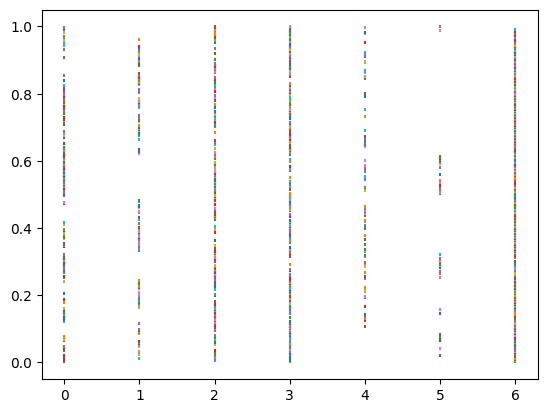

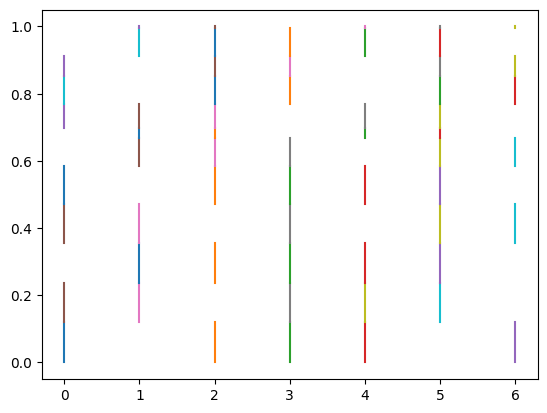

In [ ]:
N = 7
inclusion = np.random.rand(N)
inlcusion = np.array([.38, .3, .42, .65, .25, .1, .9])
D = Design(inlcusion)
for i in range(10000):
    D.iterate()
D.merge_identical()
D.show()
x = np.random.rand(N)
x = np.array([1,2,4,5,7,8,9])
a = AStarFast(VarNHT(x, inclusion))
a.run(max_iterations= 100000, num_new_nodes= 4, max_open_set_size= 1000, num_changes= 1)
a.best_design.show()
#for sample in a.best_design:
 #   print(sample)